In [1]:
library(DESeq2)
library(RColorBrewer)
library(reshape2)
library("gplots")
library("GGally")                      # Load GGally package
library(goseq)
library(readxl)
library(tidyverse)
library("pheatmap")

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: 'BiocGenerics'


The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs


The following objects are masked from 'package:base':

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min



Attaching package: 'S4Vectors'


The following objects are masked from 'package:base':

    expand.grid, I, unname


Loading required package: IRanges


Attaching package: 'IRanges'


The following object is masked from 'package:grDevices':

    windows


Loading required package: GenomicRanges

Loading req

In [5]:
library(ggfortify)

In [23]:
library(corrplot)

corrplot 0.92 loaded



In [6]:
options(repr.plot.width = 10, repr.plot.height = 10, repr.plot.res = 300)

In [7]:
PRO_COLOR = 'MediumSeaGreen'
ALT_COLOR = 'Gold'
HCOLOR = '#E26A2C'
HCOLOR = '#984215'
 
HCOLOR_light = '#FDA65D'
PCOLOR = '#99cc99'
PCOLOR_light = '#aad5aa'

tpal = brewer.pal(5, "Purples")
gpal = brewer.pal(4, 'Dark2')
ann_colors = list(
    Timepoint = c('1'=tpal[1], '2'=tpal[2], '3'=tpal[3], 
                  '4'=tpal[4], '5'=tpal[5]),
    Group = c(P = PCOLOR_light, C = PRO_COLOR),
    treatment = c(ref = gpal[2], long.term=gpal[4])
)
#forder = ['med4 (AX)', 'med4 (CC)', '1A3 (CC)', '1A3 (AX)']
#fpal = [PCOLOR_light, PRO_COLOR, HCOLOR, HCOLOR_light,  ]


In [8]:
list.files('data')

[1] "A_axenic_proteome.txt"                                                                          
 [2] "A_axenic_proteome_norm.txt"                                                                     
 [3] "C_ALT_proteome.txt"                                                                             
 [4] "C_ALT_proteome_norm.txt"                                                                        
 [5] "C_PRO_proteome.txt"                                                                             
 [6] "C_PRO_proteome_norm.txt"                                                                        
 [7] "Nov22_Processing.xlsx"                                                                          
 [8] "P_axenic_proteome.txt"                                                                          
 [9] "P_axenic_proteome_norm.txt"                                                                     
[10] "uniprot-compressed_true_download_true_fields_accession_2Cid_2Cprotei-2023.01.11-12.43.22.99.txt"

In [9]:

dfA = read.csv(file.path('data', 'P_axenic_proteome_norm.txt'), sep='\t', comment.char = '#' )
dfC = read.csv(file.path('data', 'C_PRO_proteome_norm.txt'), sep='\t', comment.char = '#'  )


In [10]:
fname_hcounts = file.path('..', 'RNASEQ', 'data', 'MED4_counts_combined.txt')
hcdf = read.csv(fname_hcounts, sep='\t' )
hgenes = hcdf[,c(1,2,3,4,5)]
hpath_fname = file.path('..', 'genomes', 'MED4', 'MED4_pathways.csv')
hpath_df = read.csv(hpath_fname)
hpath_df = left_join(hgenes, hpath_df, by='protein_id')

Warning message in left_join(hgenes, hpath_df, by = "protein_id"):
"Each row in `x` is expected to match at most 1 row in `y`.
ℹ Row 1 of `x` matches multiple rows.
ℹ If multiple matches are expected, set `multiple = "all"` to silence this warning."


In [11]:
hpath_df_to_export = hpath_df %>% 
     group_by(gene_id) %>% 
     mutate(
         main = paste0(unique(main), collapse = ";"),
         sub = paste0(unique(sub), collapse = ";"),
         path = paste0(unique(path), collapse = ";"),
         ecpath = paste0(unique(ecpath), collapse = ";")
     ) %>%
    ungroup() %>%
    distinct(gene_id, .keep_all = TRUE)


In [12]:
names(dfA)
names(dfC)

[1] "P1_1"       "P1_2"       "P1_3"       "P2_1"       "P2_2"      
 [6] "P2_3"       "P3_1"       "P3_2"       "P3_3"       "P5_1"      
[11] "P5_2"       "P5_3"       "Species"    "name"       "protein_id"

[1] "C1_1"       "C1_2"       "C1_3"       "C2_1"       "C2_2"      
 [6] "C2_3"       "C3_1"       "C3_2"       "C3_3"       "C4_1"      
[11] "C4_2"       "C4_3"       "C5_1"       "C5_2"       "C5_3"      
[16] "Species"    "name"       "protein_id"

In [13]:
mdf = bind_rows(
    pivot_longer(dfA, cols = starts_with('P', ignore.case = FALSE), names_to = 'Sample', values_to = 'Intensity'),
    pivot_longer(dfC, cols = starts_with('C'), names_to = 'Sample', values_to = 'Intensity')
)


In [14]:
#mdf = left_join(mdf, hpath_df_to_export, by='protein_id')

In [15]:
mdf = mdf %>% 
   mutate(Group = substr(mdf$Sample, 1,1)) %>%
   mutate(Timepoint = substr(mdf$Sample, 2,2)) %>%
   mutate(replicate = substr(mdf$Sample, 4,4)) %>%
   mutate(Group.Timepoint = substr(mdf$Sample, 1,2)) 

In [16]:
head(mdf)

Species,name,protein_id,Sample,Intensity,Group,Timepoint,replicate,Group.Timepoint
<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>
PRO,photosystem I core protein PsaA,WP_011133152.1,P1_1,7.738641,P,1,1,P1
PRO,photosystem I core protein PsaA,WP_011133152.1,P1_2,7.620350,P,1,2,P1
PRO,photosystem I core protein PsaA,WP_011133152.1,P1_3,7.848150,P,1,3,P1
PRO,photosystem I core protein PsaA,WP_011133152.1,P2_1,7.722785,P,2,1,P2
PRO,photosystem I core protein PsaA,WP_011133152.1,P2_2,7.688363,P,2,2,P2
PRO,photosystem I core protein PsaA,WP_011133152.1,P2_3,8.083828,P,2,3,P2


In [17]:
names(mdf)

[1] "Species"         "name"            "protein_id"      "Sample"         
[5] "Intensity"       "Group"           "Timepoint"       "replicate"      
[9] "Group.Timepoint"

Warning message:
"Setting row names on a tibble is deprecated."


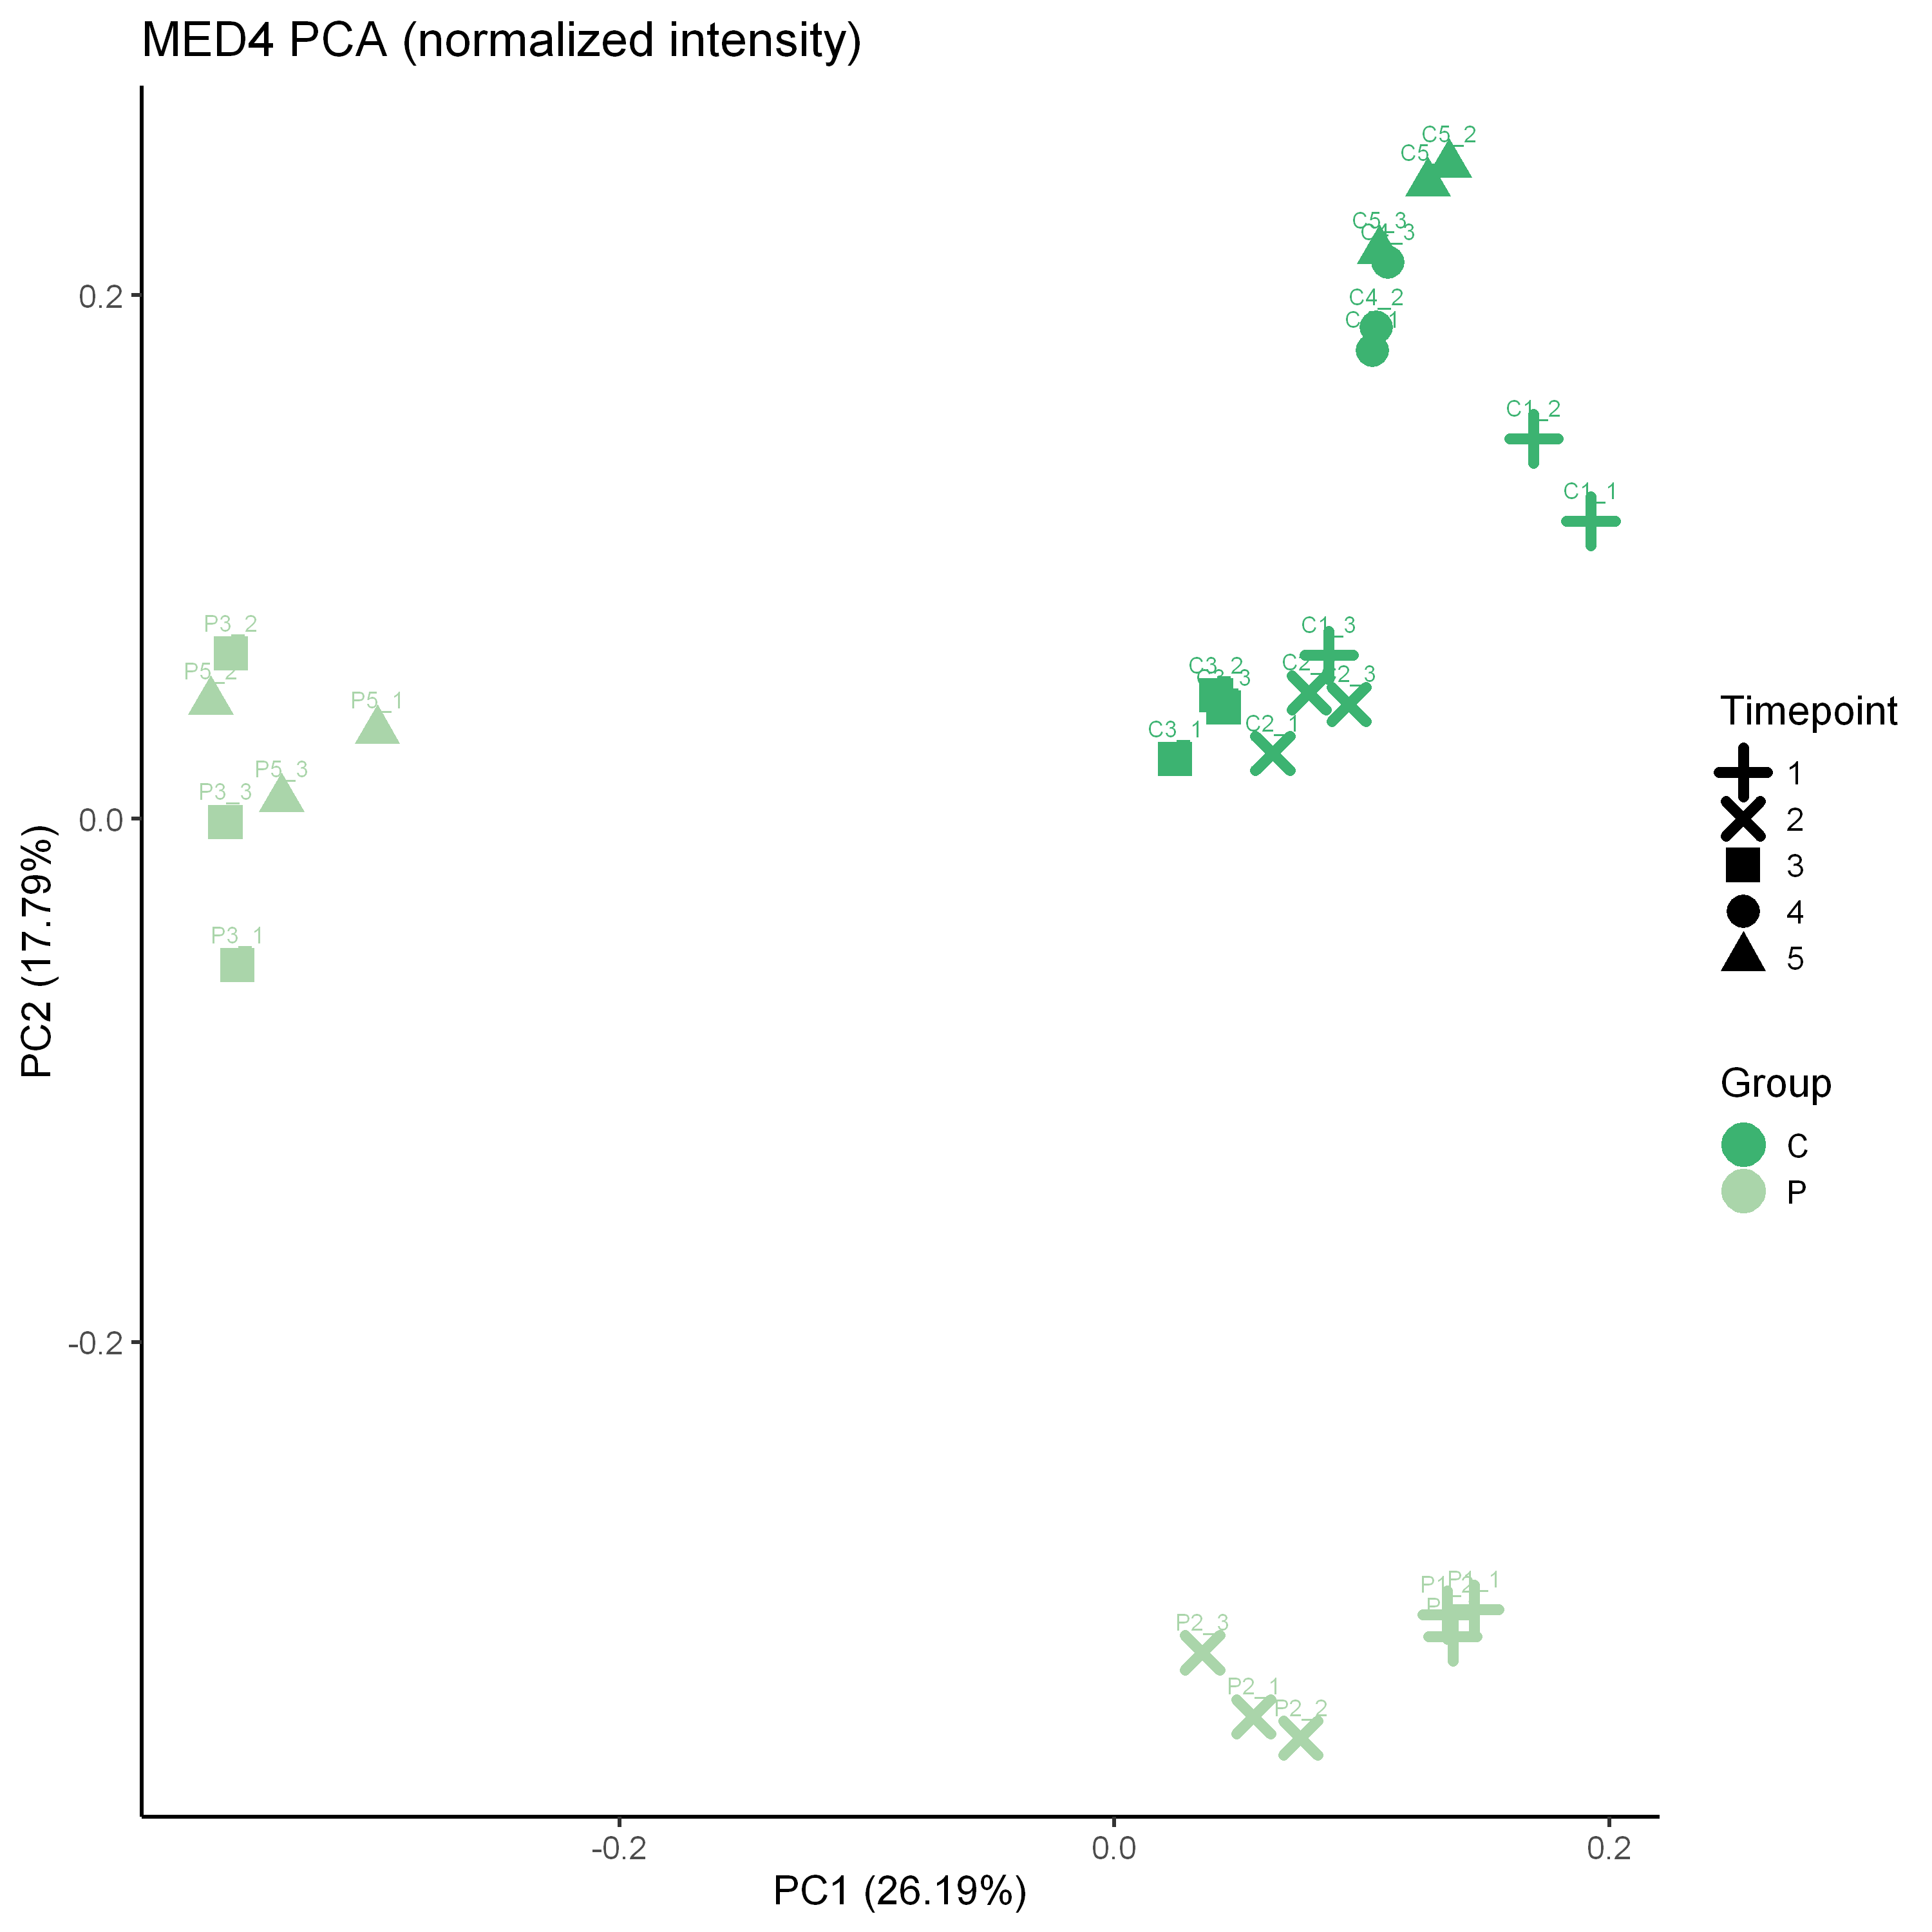

In [20]:
df = pivot_wider(
    mdf, id_cols=c('Sample', 'Group','Timepoint','replicate','Group.Timepoint'), 
    names_from='protein_id', values_from = 'Intensity')
X = df %>% select(starts_with('WP_')) 
row.names(X) = df$Sample
#X
#    as.data.frame
pca_res <- prcomp(X, scale. = TRUE)
p = autoplot(pca_res, data=df, colour='Group', shape='Timepoint', label=TRUE, size =4, stroke=3,
         label.vjust = -1.3, label.size = 3) +
  scale_color_manual(values = ann_colors$Group) +
  scale_shape_manual(values=c(3,4, 15,16,17))+
  ggtitle("MED4 PCA (normalized intensity)") +
  theme_classic(base_size = 15)  

p$layers[[1]]$aes_params$stroke <- 3
p

Warning message:
"Setting row names on a tibble is deprecated."


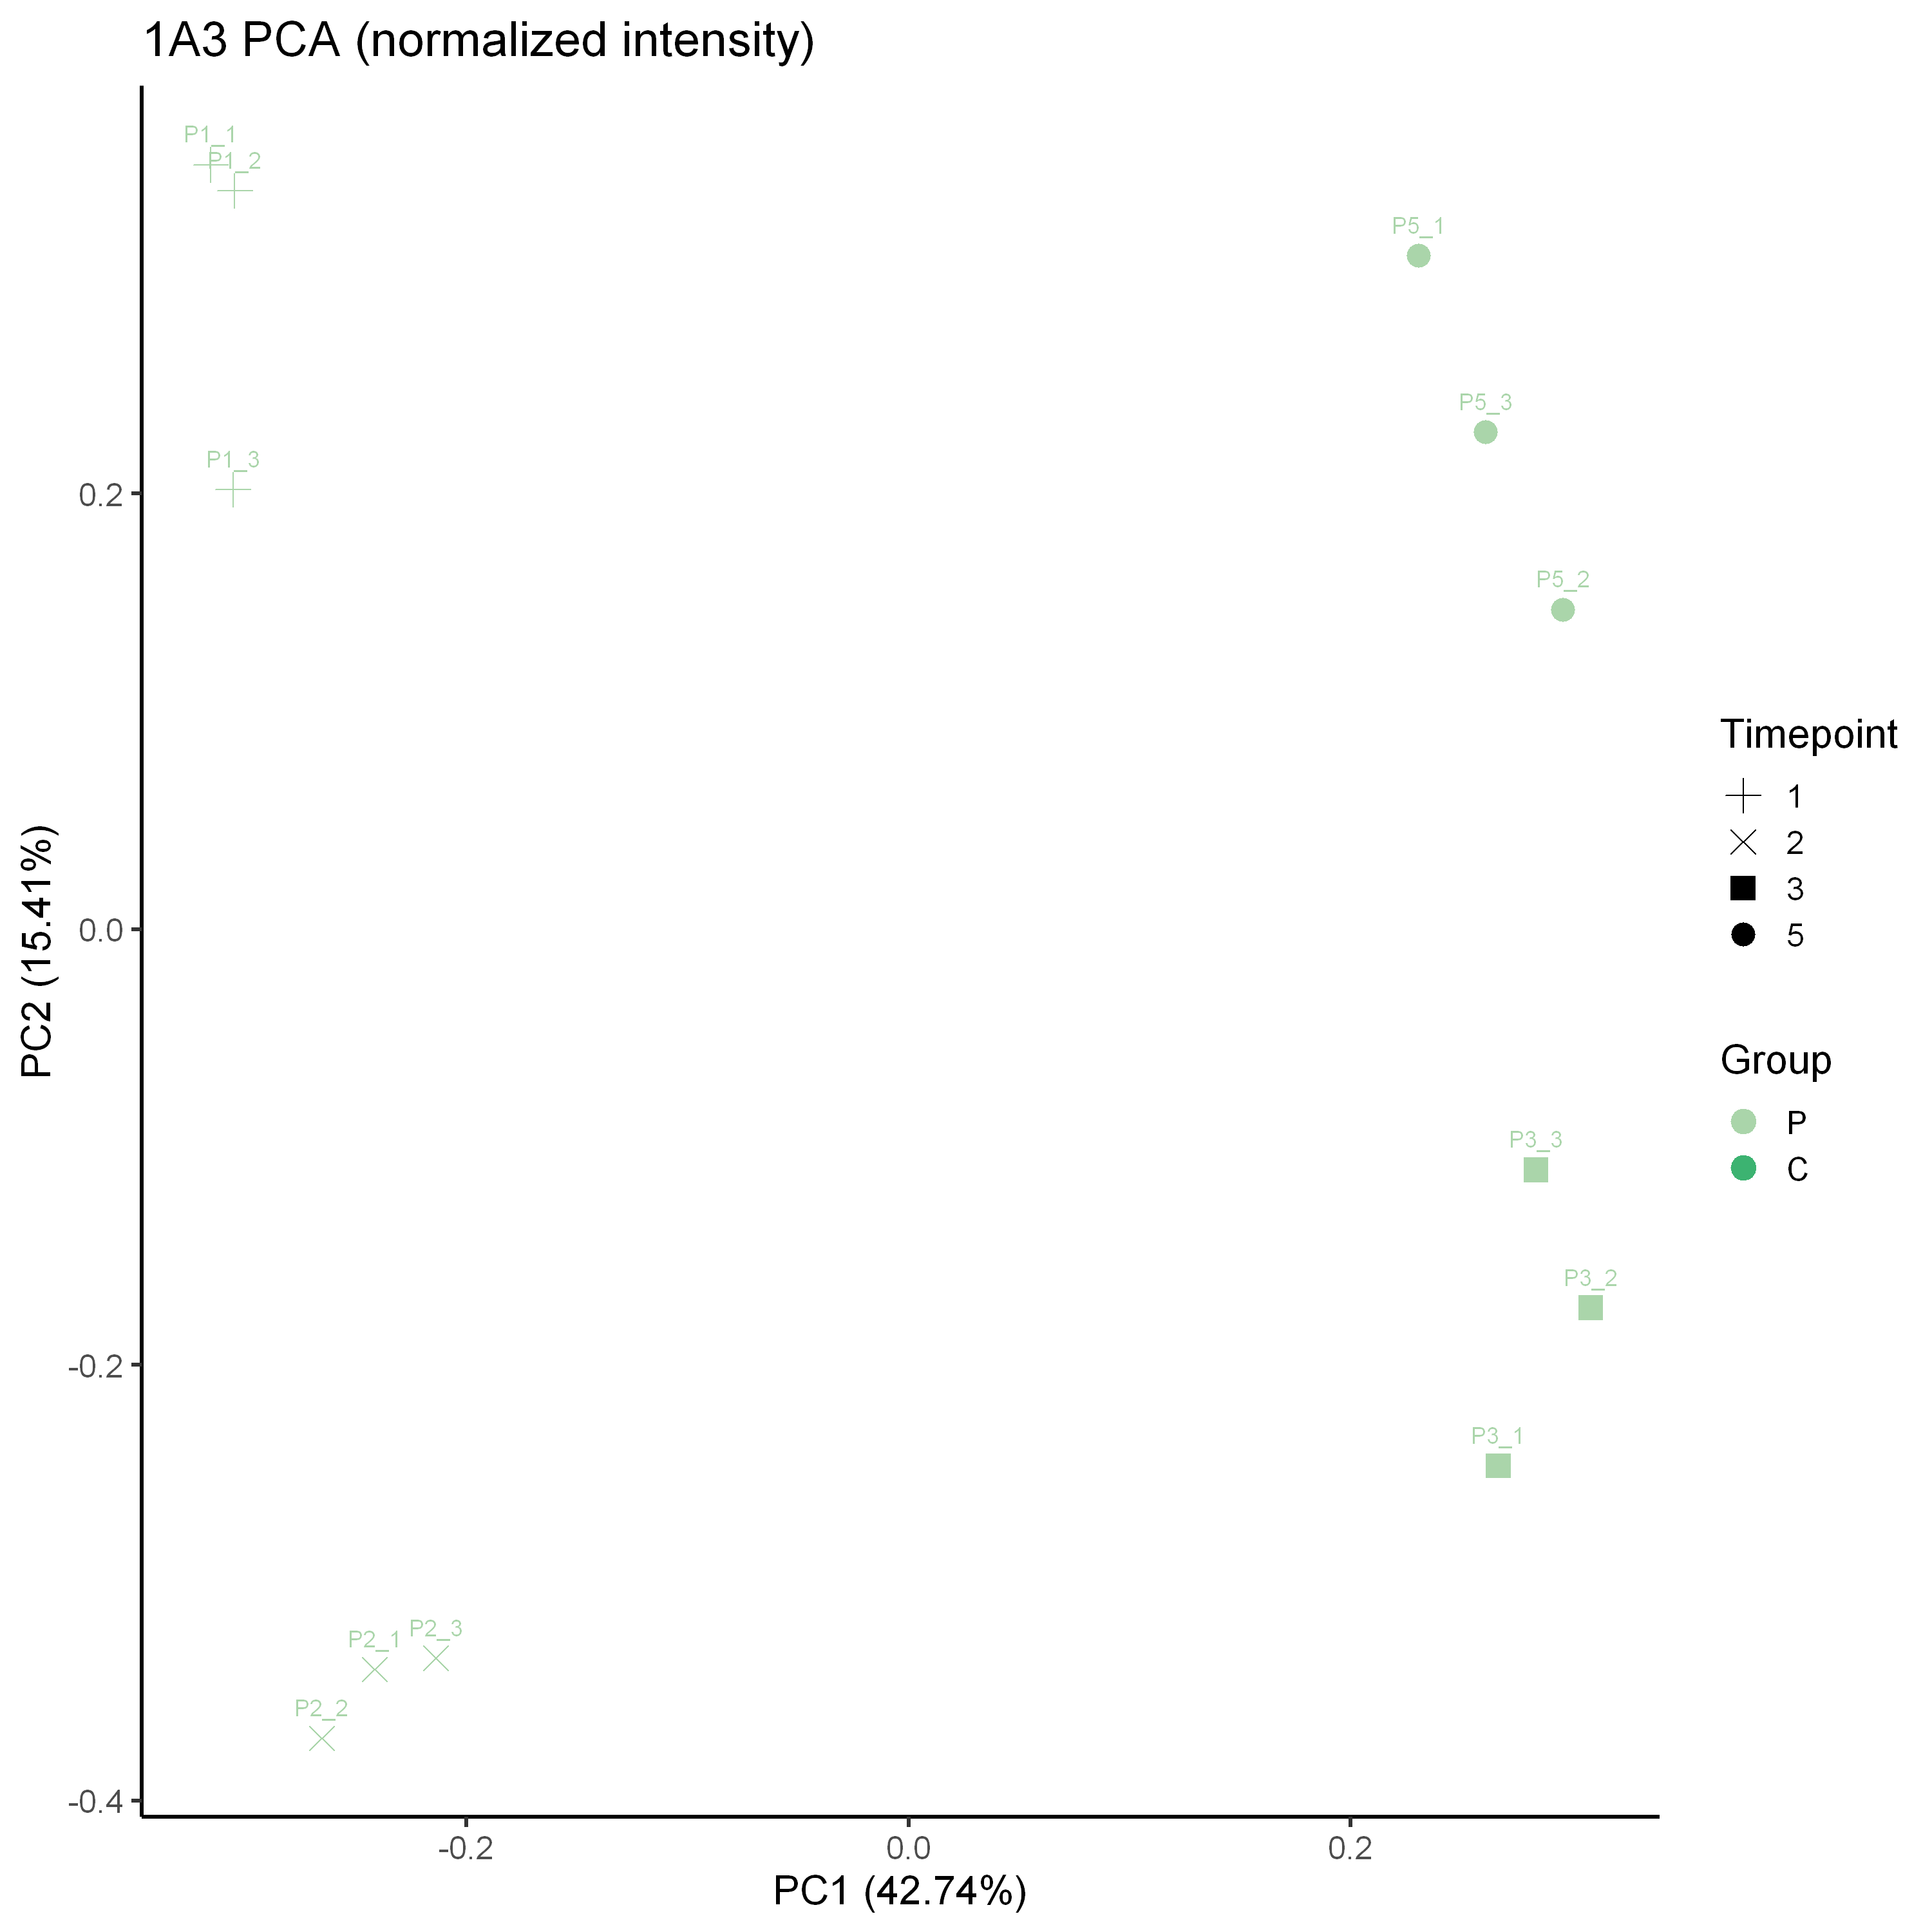

In [21]:
df = pivot_wider(
    mdf, id_cols=c('Sample', 'Group','Timepoint','replicate','Group.Timepoint'), 
    names_from='protein_id', values_from = 'Intensity') 
df = df %>% filter(Group=='P')
X = df %>% select(starts_with('WP_')) 
row.names(X) = df$Sample
#X
#    as.data.frame
pca_res <- prcomp(X, scale. = TRUE)
autoplot(pca_res, data=df, colour='Group', shape='Timepoint', label=TRUE, size =4, 
         label.vjust = -1.3, label.size = 3) +
  scale_color_manual(values = ann_colors$Group) +
  scale_shape_manual(values=c(3,4, 15,16,17))+
  ggtitle("1A3 PCA (normalized intensity)") +
  theme_classic(base_size = 15)  


Warning message:
"Setting row names on a tibble is deprecated."


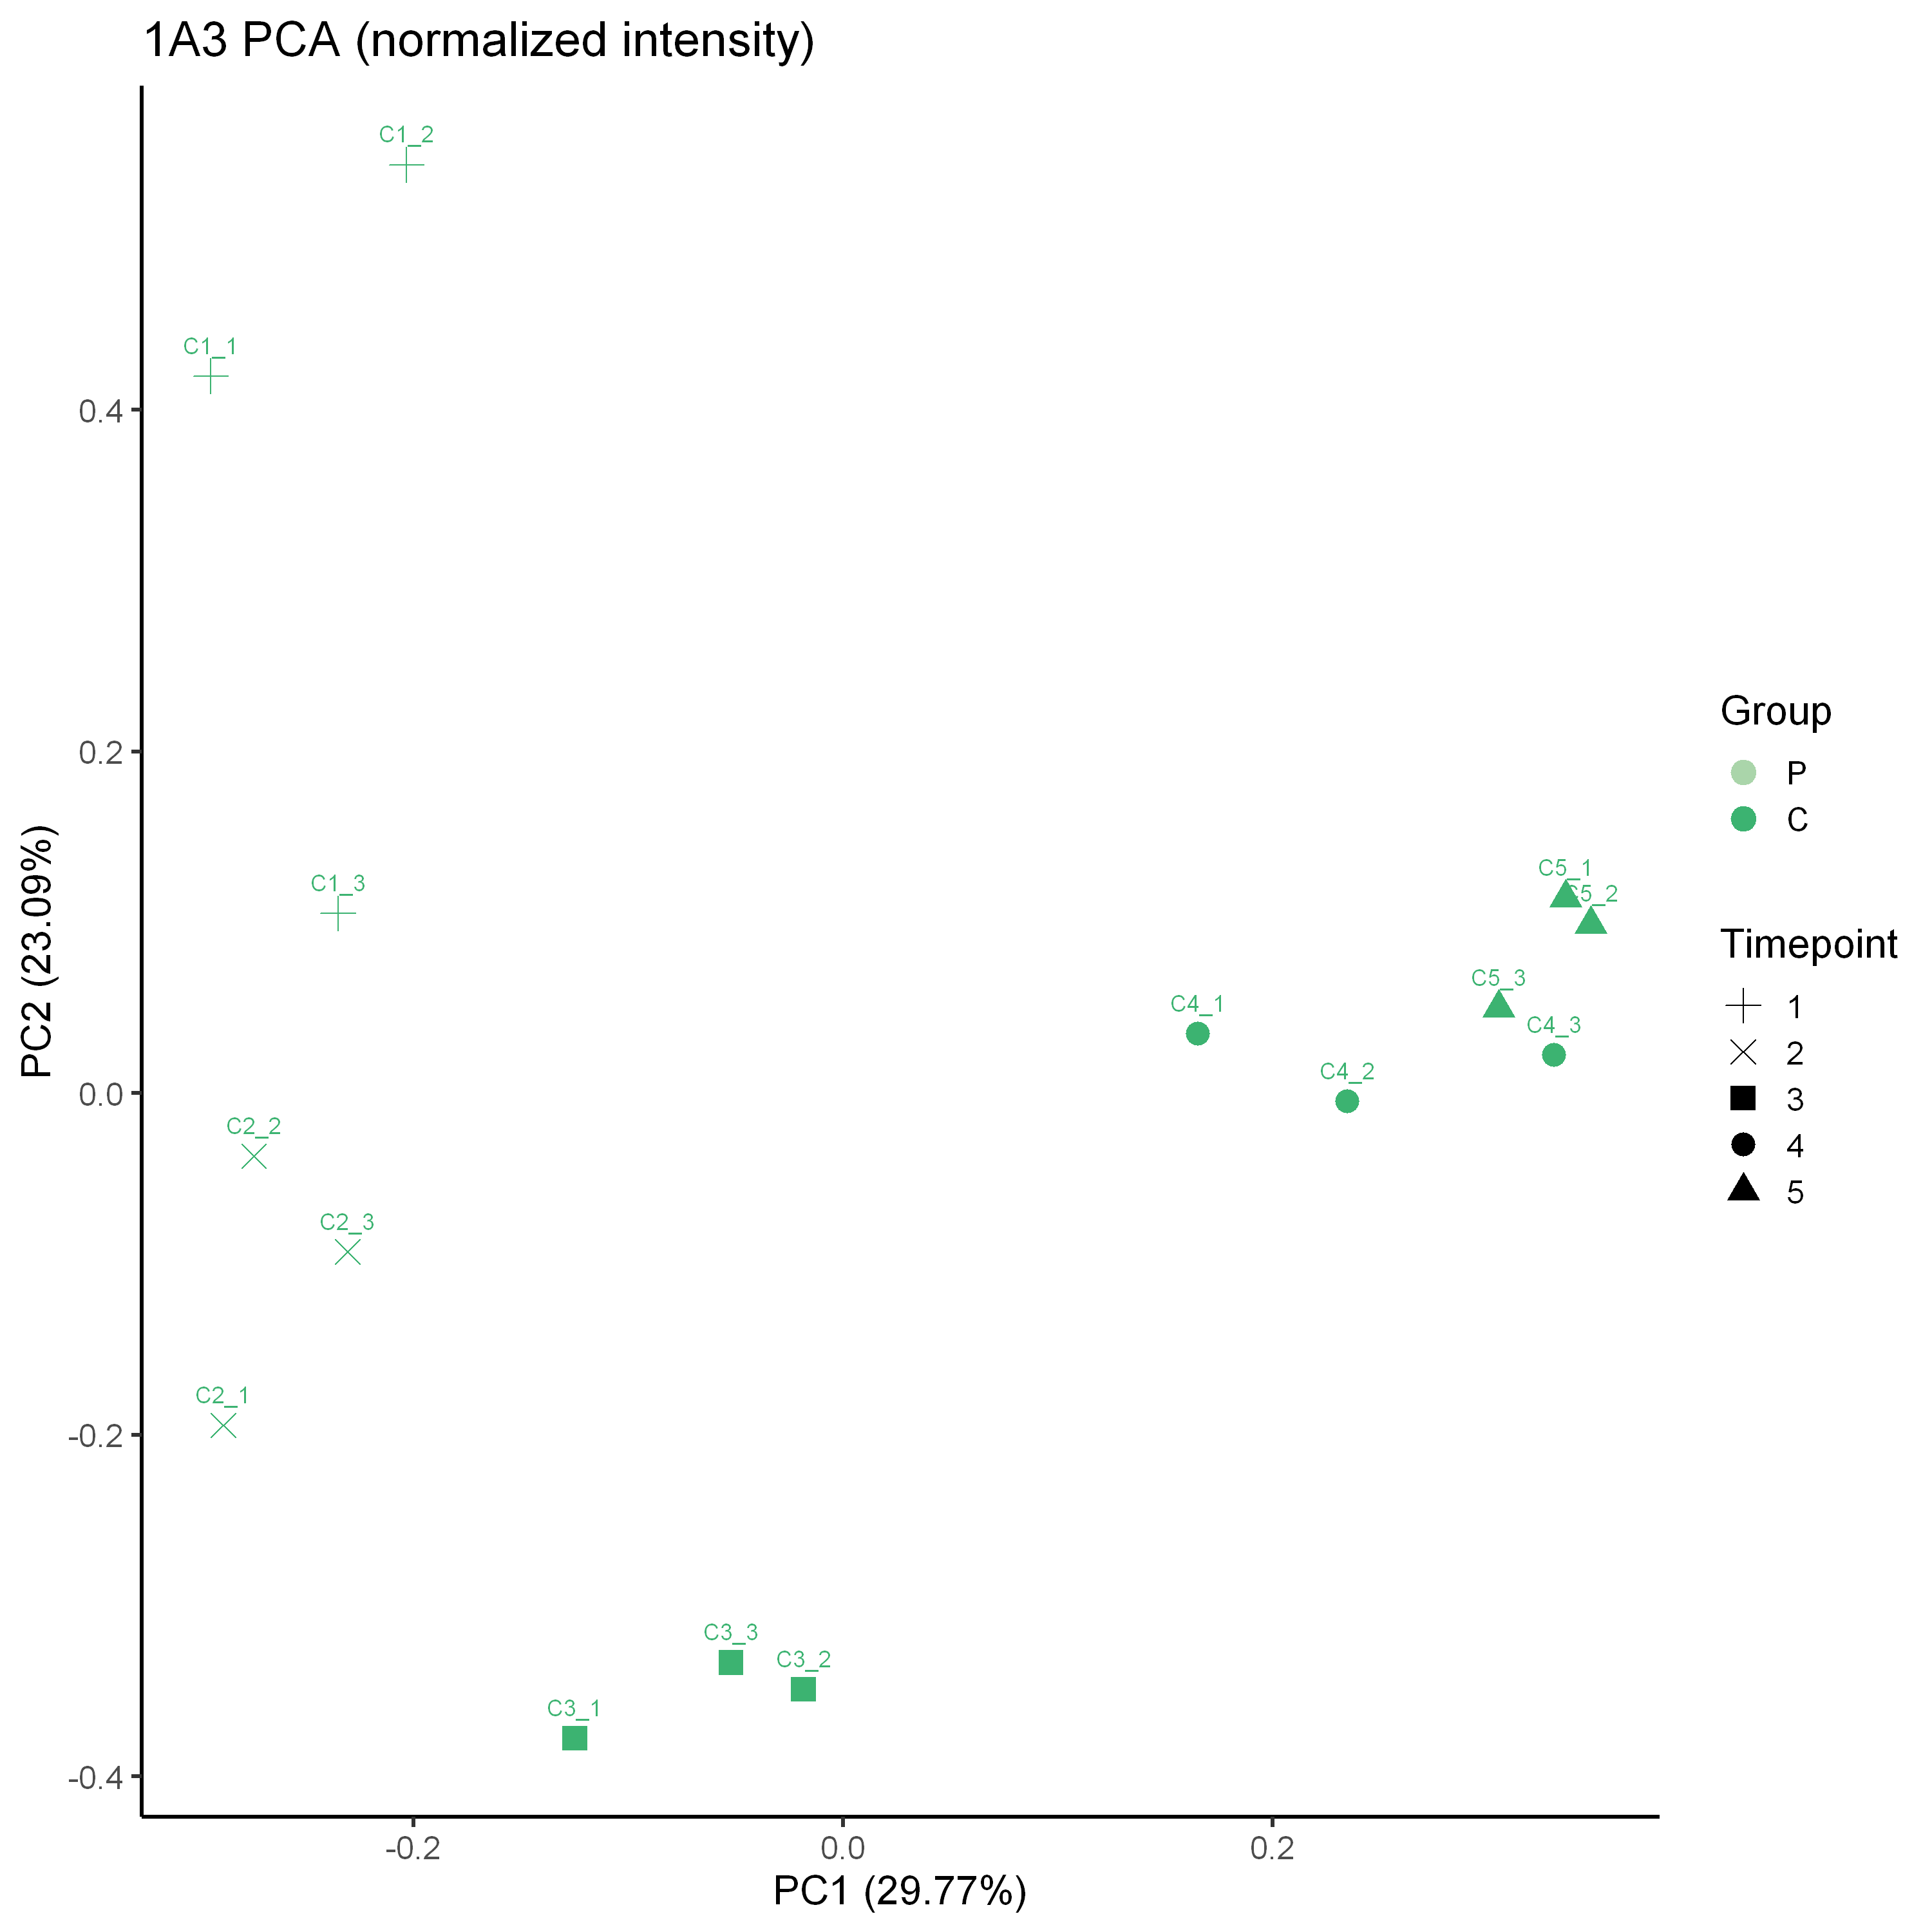

In [22]:
df = pivot_wider(
    mdf, id_cols=c('Sample', 'Group','Timepoint','replicate','Group.Timepoint'), 
    names_from='protein_id', values_from = 'Intensity') 
df = df %>% filter(Group=='C')
X = df %>% select(starts_with('WP_')) 
row.names(X) = df$Sample
#X
#    as.data.frame
pca_res <- prcomp(X, scale. = TRUE)
autoplot(pca_res, data=df, colour='Group', shape='Timepoint', label=TRUE, size =4, 
         label.vjust = -1.3, label.size = 3) +
  scale_color_manual(values = ann_colors$Group) +
  scale_shape_manual(values=c(3,4, 15,16,17))+
  ggtitle("1A3 PCA (normalized intensity)") +
  theme_classic(base_size = 15)  


In [23]:
names(mdf)

[1] "Species"         "name"            "protein_id"      "Sample"         
[5] "Intensity"       "Group"           "Timepoint"       "replicate"      
[9] "Group.Timepoint"

`summarise()` has grouped output by 'protein_id'. You can override using the `.groups` argument.


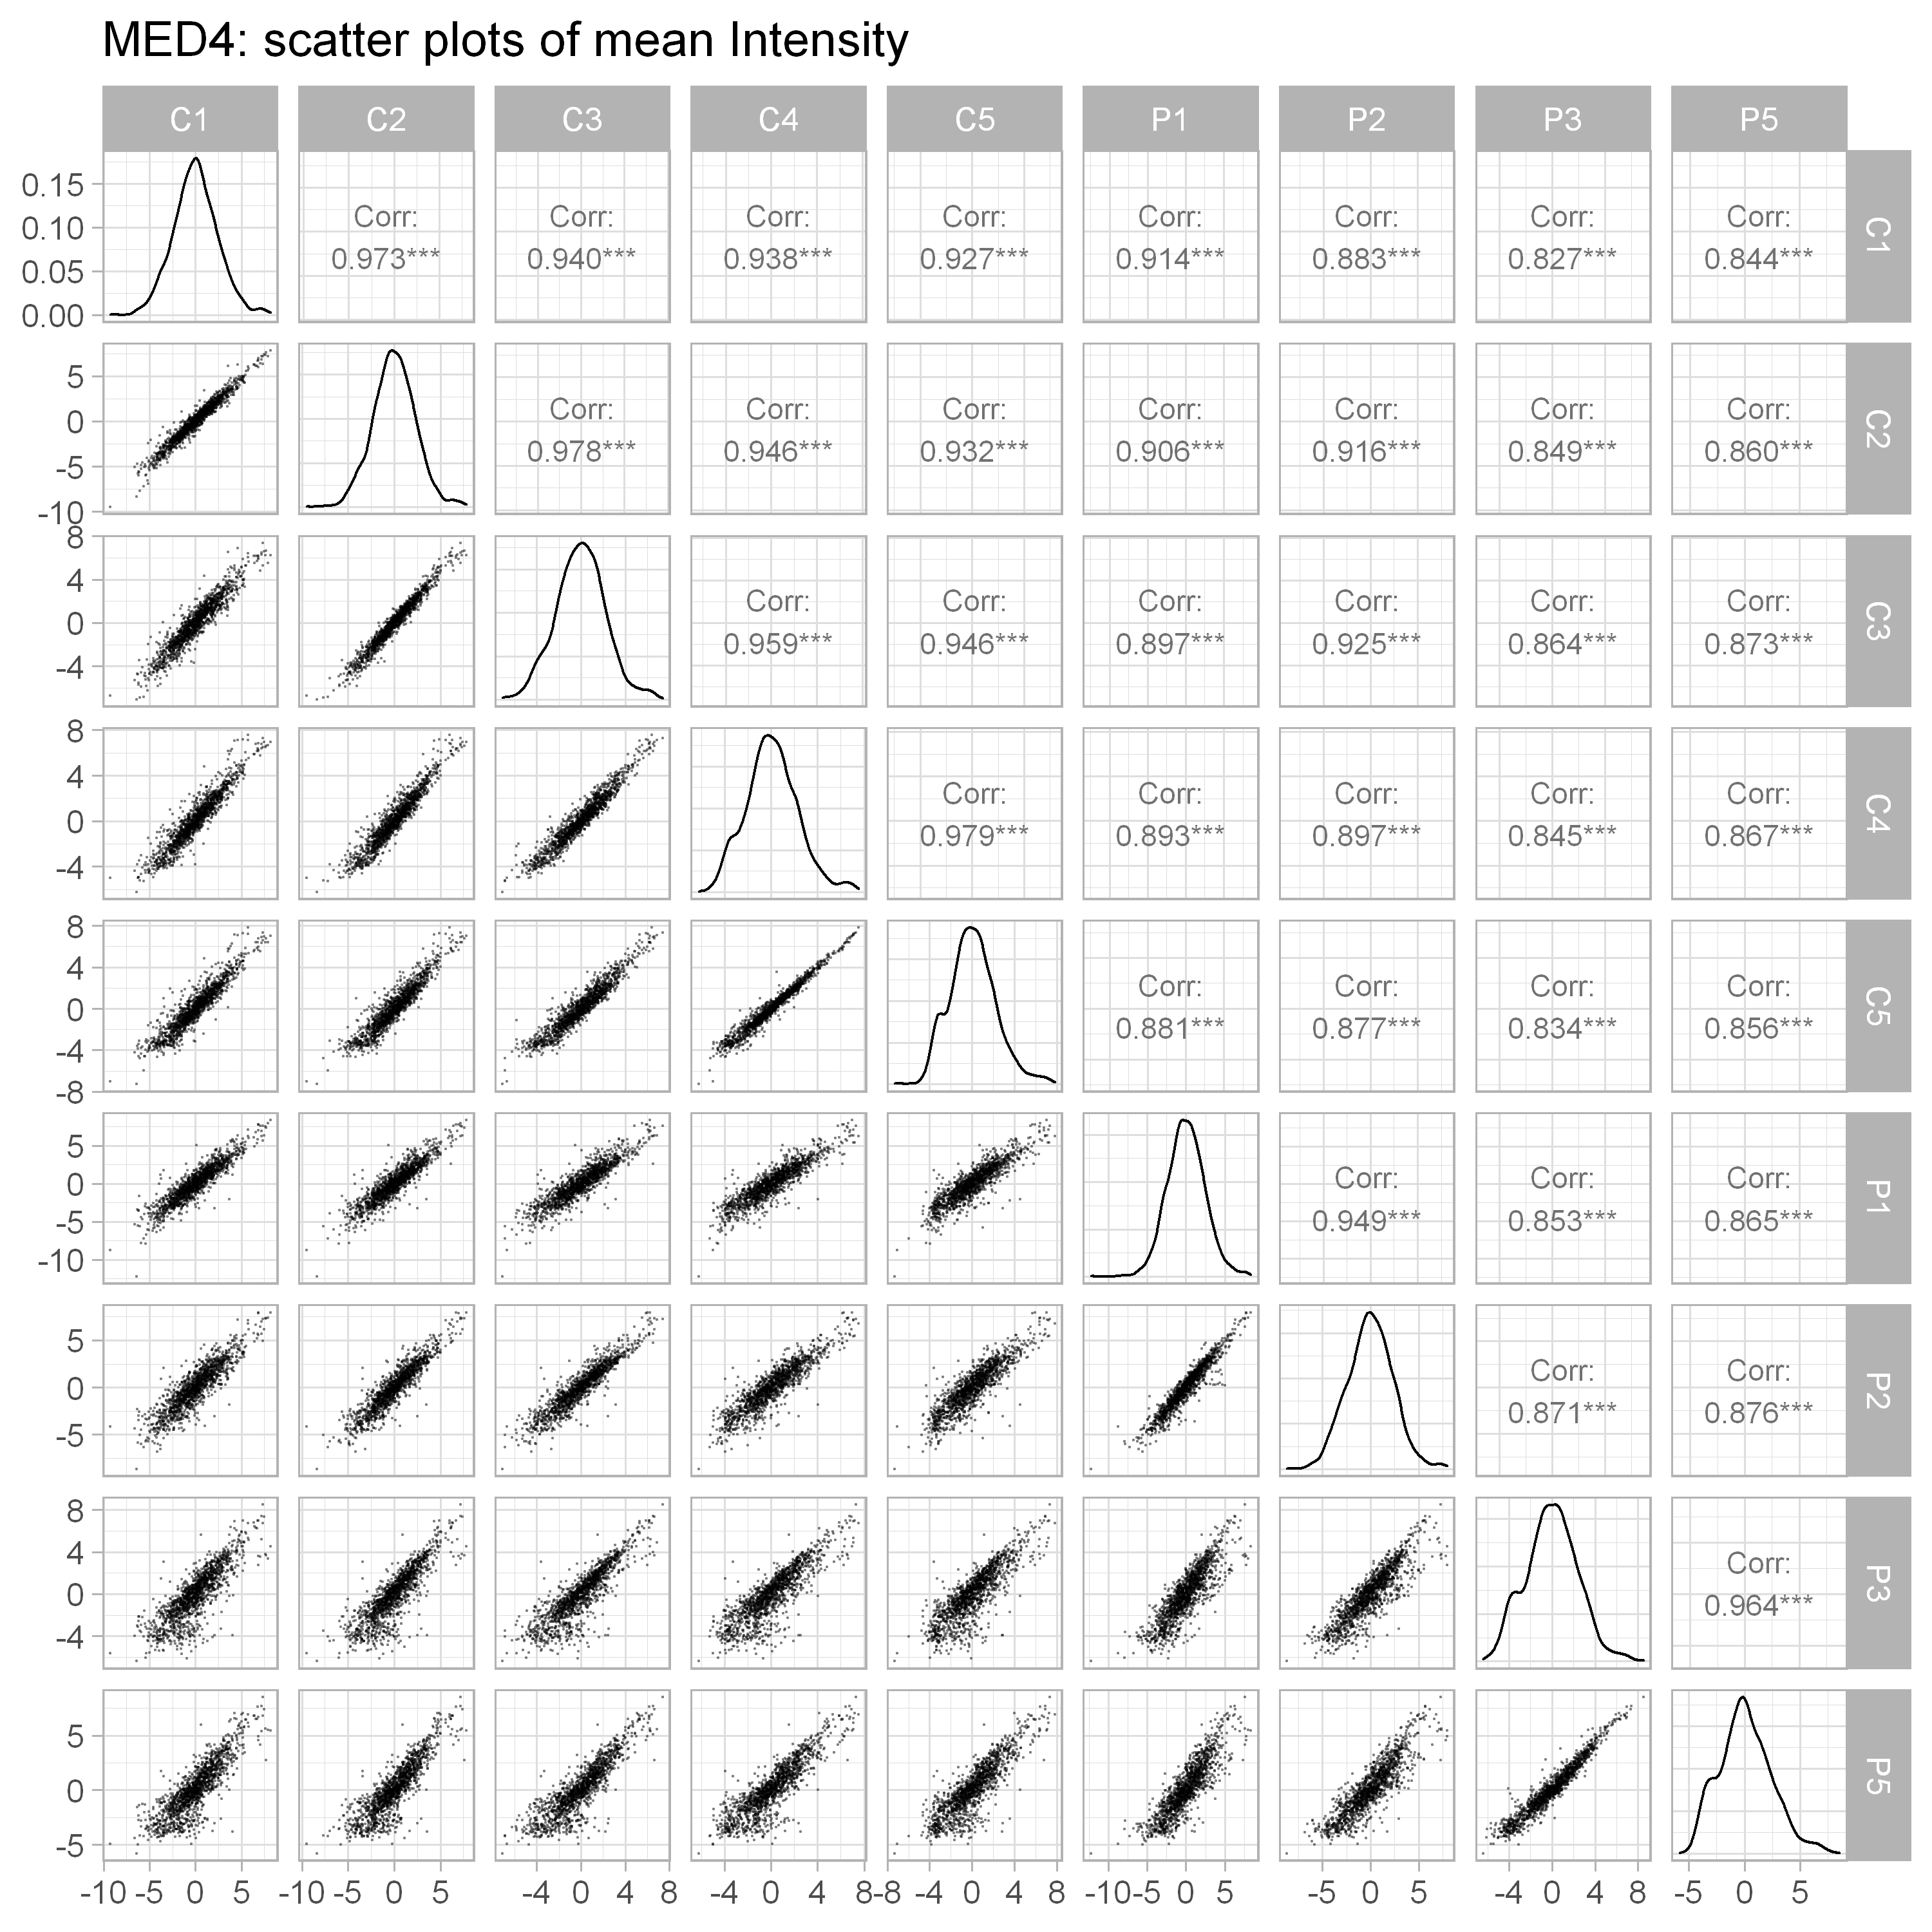

In [24]:
mdf %>%
   group_by(protein_id, Group.Timepoint)  %>%
   summarise(mean_Intensity = mean(Intensity)) %>%
   pivot_wider(names_from = Group.Timepoint, values_from = mean_Intensity) %>%
ggpairs(columns = c(2:10), lower = list(continuous = wrap("points", alpha = 0.3, size=0.1)),
        title='MED4: scatter plots of mean Intensity'
       ) +
  theme_light(base_size = 15)
  
   

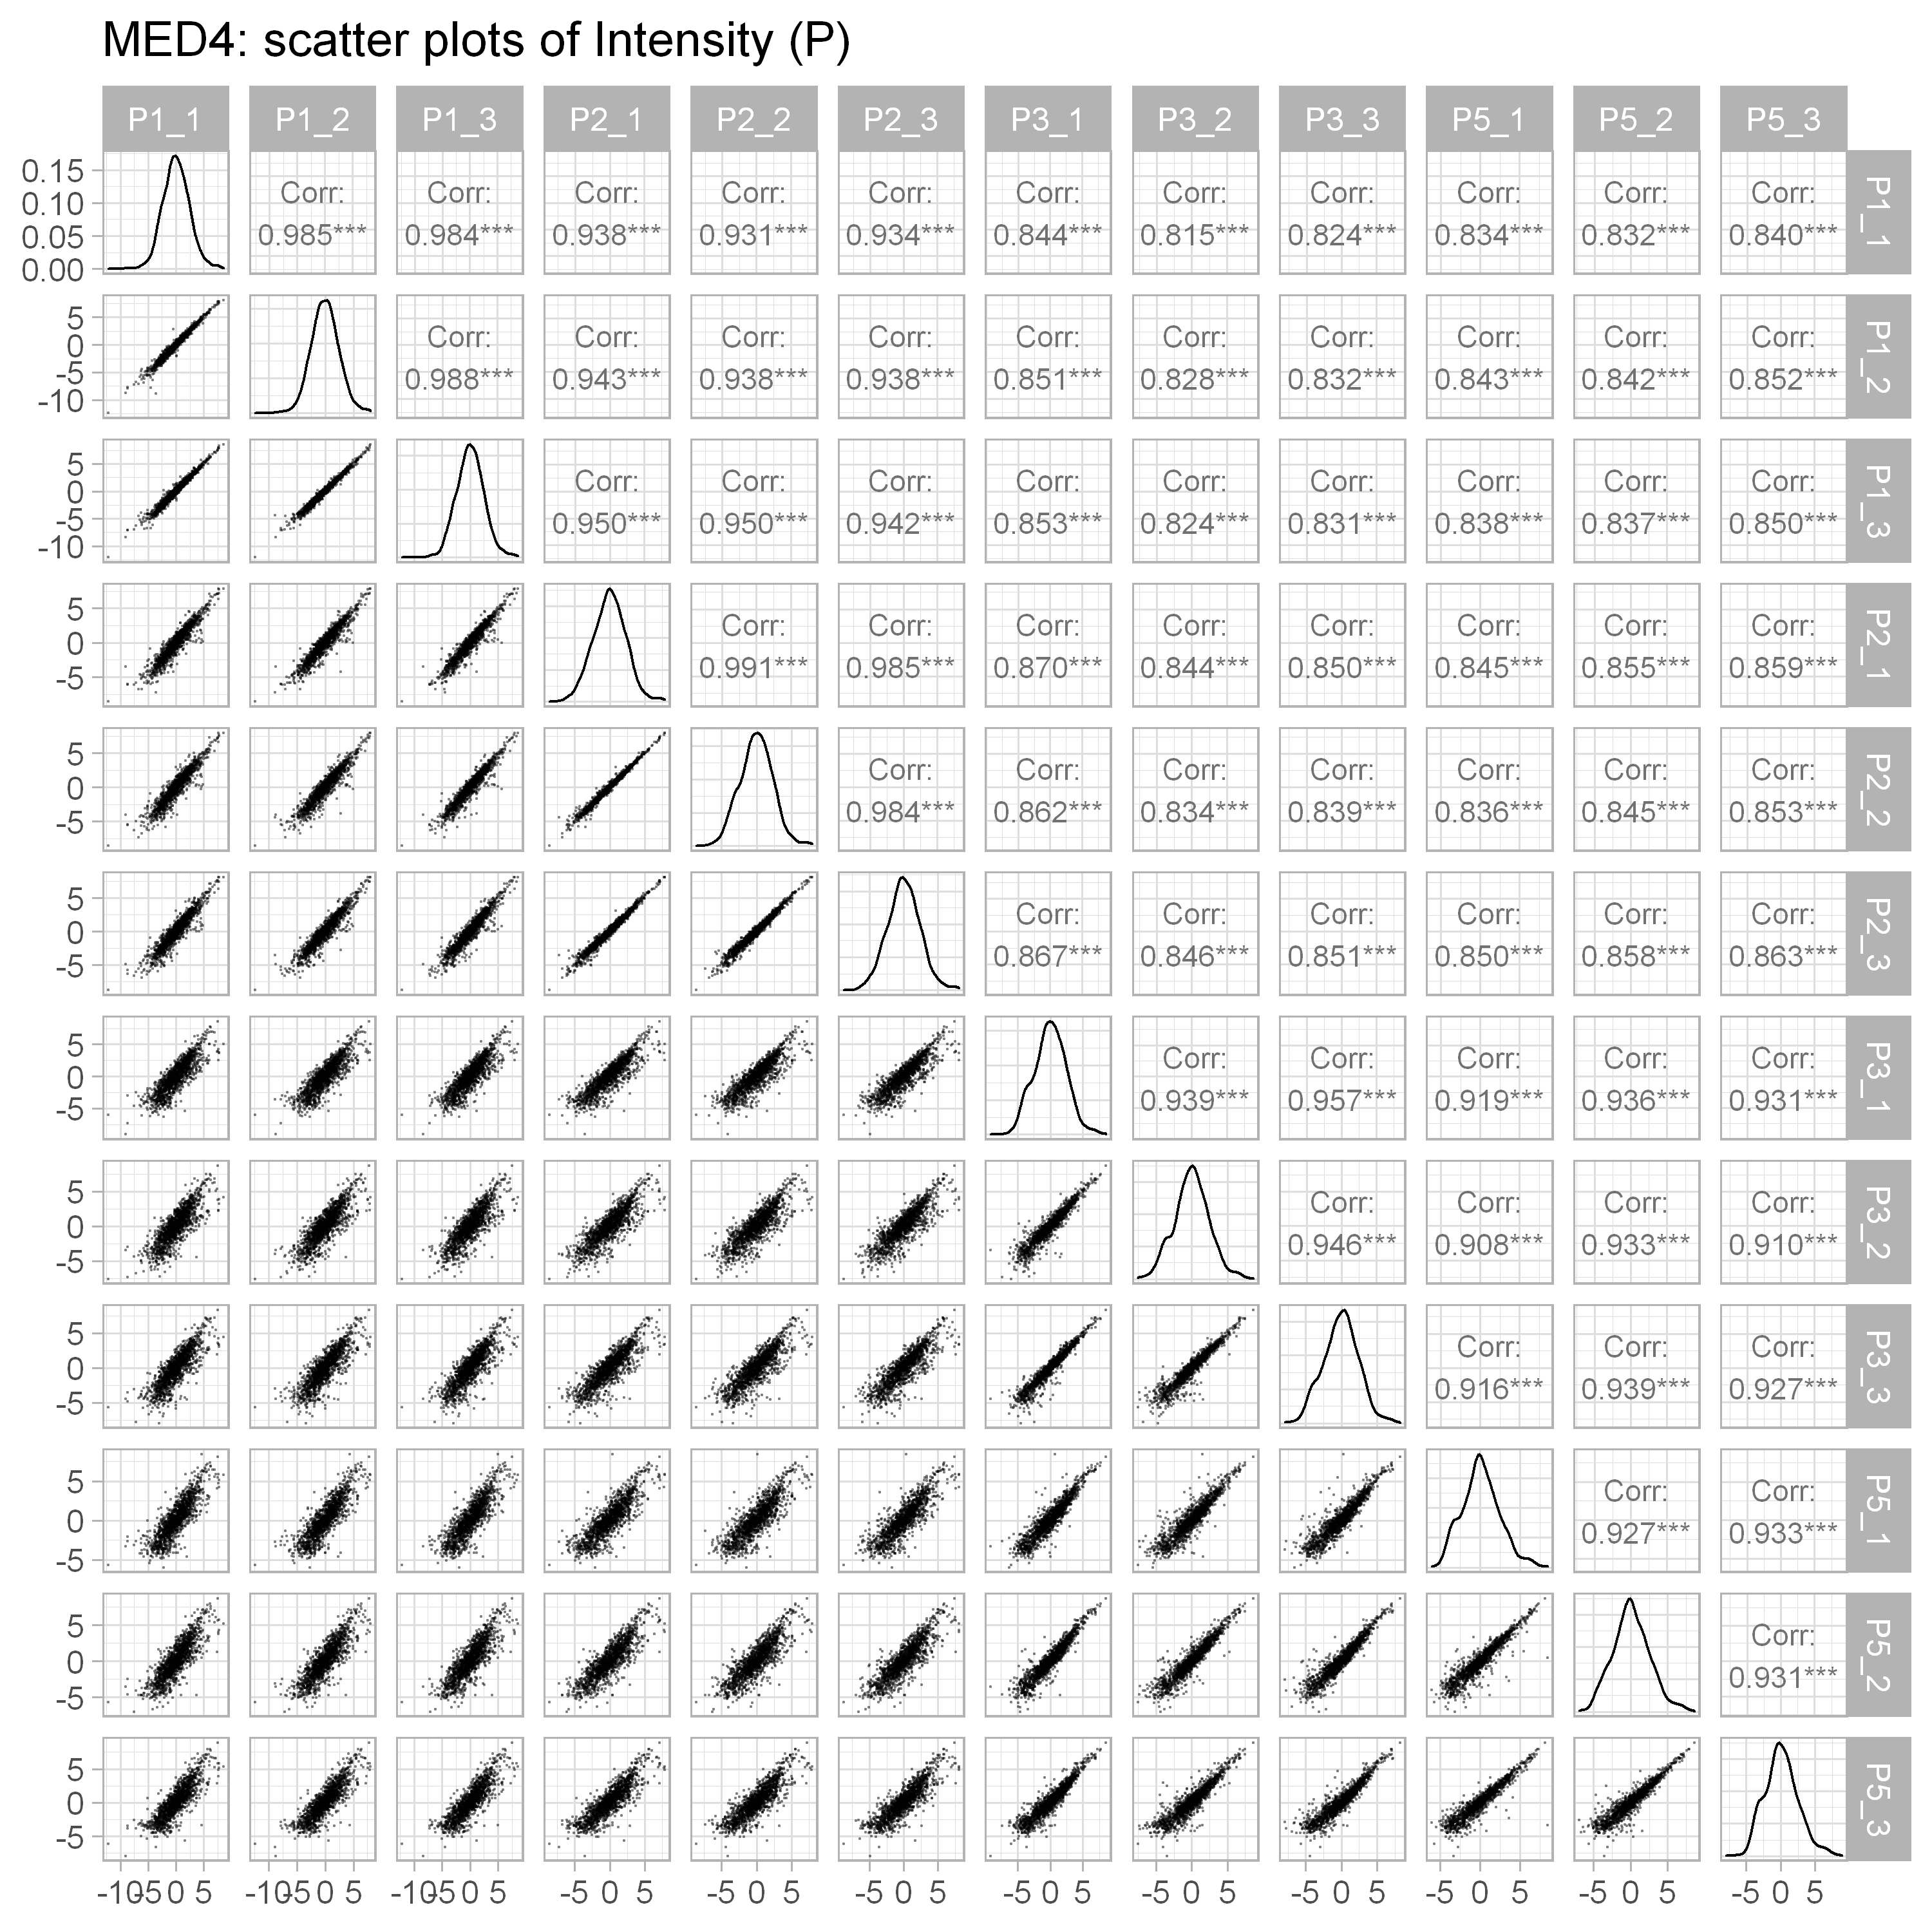

In [30]:
mdf %>%

   filter(Group == 'P') %>%
   select(Sample, Intensity, protein_id) %>%
   #group_by(protein_id, Group.Timepoint)  %>%
   #summarise(mean_Intensity = mean(Intensity)) %>%
   pivot_wider(names_from = Sample, values_from = Intensity) %>%
ggpairs(columns = c(2:13), lower = list(continuous = wrap("points", alpha = 0.3, size=0.1)),
        title='MED4: scatter plots of Intensity (P)'
       ) +
  theme_light(base_size = 15)
  
   

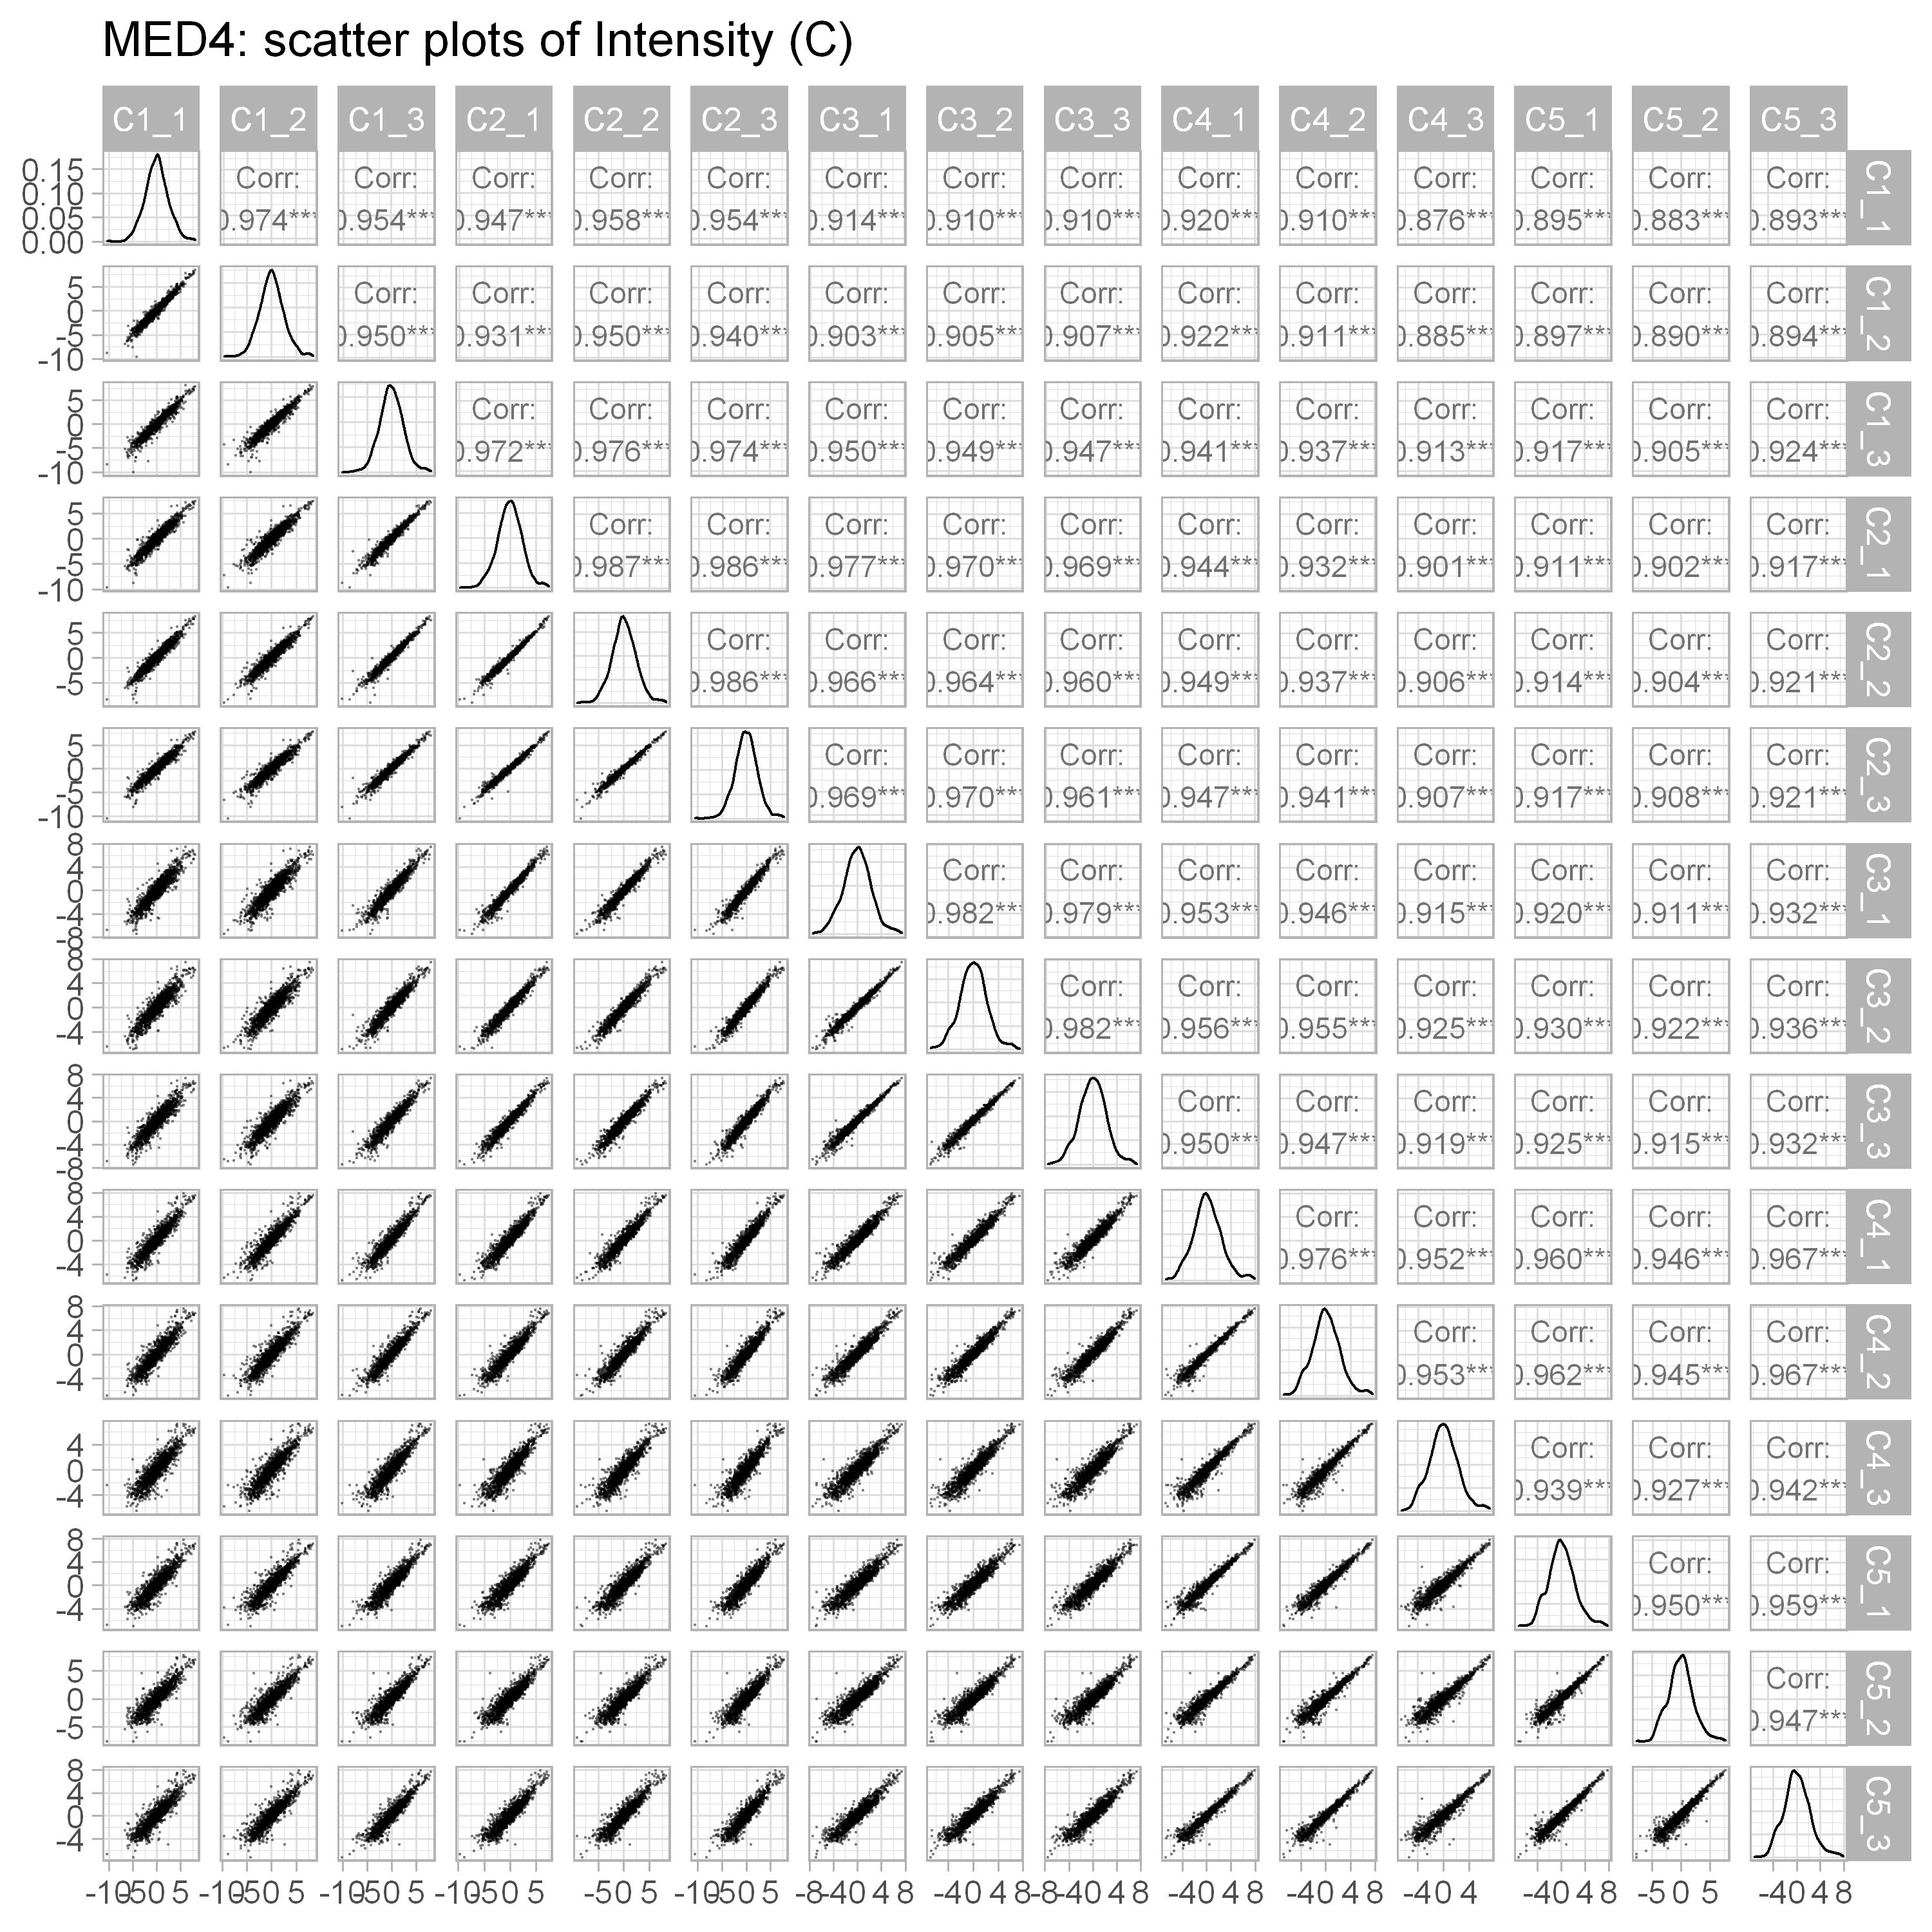

In [29]:
mdf %>%

   filter(Group == 'C') %>%
   select(Sample, Intensity, protein_id) %>%
   #group_by(protein_id, Group.Timepoint)  %>%
   #summarise(mean_Intensity = mean(Intensity)) %>%
   pivot_wider(names_from = Sample, values_from = Intensity) %>%
ggpairs(columns = c(2:16), lower = list(continuous = wrap("points", alpha = 0.3, size=0.1)),
        title='MED4: scatter plots of Intensity (C)'
       ) +
  theme_light(base_size = 15)
  
   

In [21]:
cdf = pivot_wider(
    mdf, id_cols=c('protein_id'), 
    names_from='Sample', values_from = 'Intensity') %>% column_to_rownames('protein_id')

head(cdf)

,P1_1,P1_2,P1_3,P2_1,P2_2,P2_3,P3_1,P3_2,P3_3,P5_1,⋯,C2_3,C3_1,C3_2,C3_3,C4_1,C4_2,C4_3,C5_1,C5_2,C5_3
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
WP_011133152.1,7.7386408,7.6203499,7.8481503,7.722785,7.688363,8.083828,3.64851284,3.8568907,3.3048029,4.251069,⋯,7.0471382,5.907307,5.681726,6.013789,6.442933,6.190625,5.869986,5.631097,5.622811,5.790801
WP_011132825.1,4.4848280,4.6353226,4.4711151,4.201722,4.254651,4.773293,5.85159779,5.7096605,5.7461901,6.197679,⋯,5.4867344,5.422384,5.119414,5.350366,5.525350,5.311805,5.217323,5.225019,5.131183,5.484208
WP_011132757.1,0.7538214,0.9428101,0.8554344,1.582704,1.379659,1.445036,0.07066059,0.5794344,0.7629499,1.701085,⋯,0.1382465,1.484032,1.172555,1.623282,1.796254,1.768653,1.249804,2.396539,1.805673,1.867908
WP_011132404.1,2.2156134,2.5591640,2.3943443,3.128482,2.948134,3.065042,3.25779247,3.4348249,2.9038401,2.852347,⋯,2.9582615,3.158932,3.071734,3.098945,1.987695,2.223659,2.166729,1.655236,1.797973,1.505015
WP_011132401.1,4.0907907,4.3361244,4.2792282,3.850692,4.240432,4.517277,5.76839542,5.4389696,5.6560545,5.905623,⋯,4.5998344,4.815557,4.387527,4.878127,4.769757,5.128566,4.540539,4.226443,4.322953,4.435864
WP_011132785.1,3.0735979,3.0963993,2.9183502,2.796327,2.790843,2.911247,1.70523548,1.3716097,1.2683039,1.072383,⋯,2.1962414,2.331039,2.069285,2.243299,2.438903,2.340068,1.867512,2.295159,2.215280,2.061799


In [22]:
spearman_cor = cor(cdf, method='spearman')
pearson_cor = cor(cdf, method='pearson')


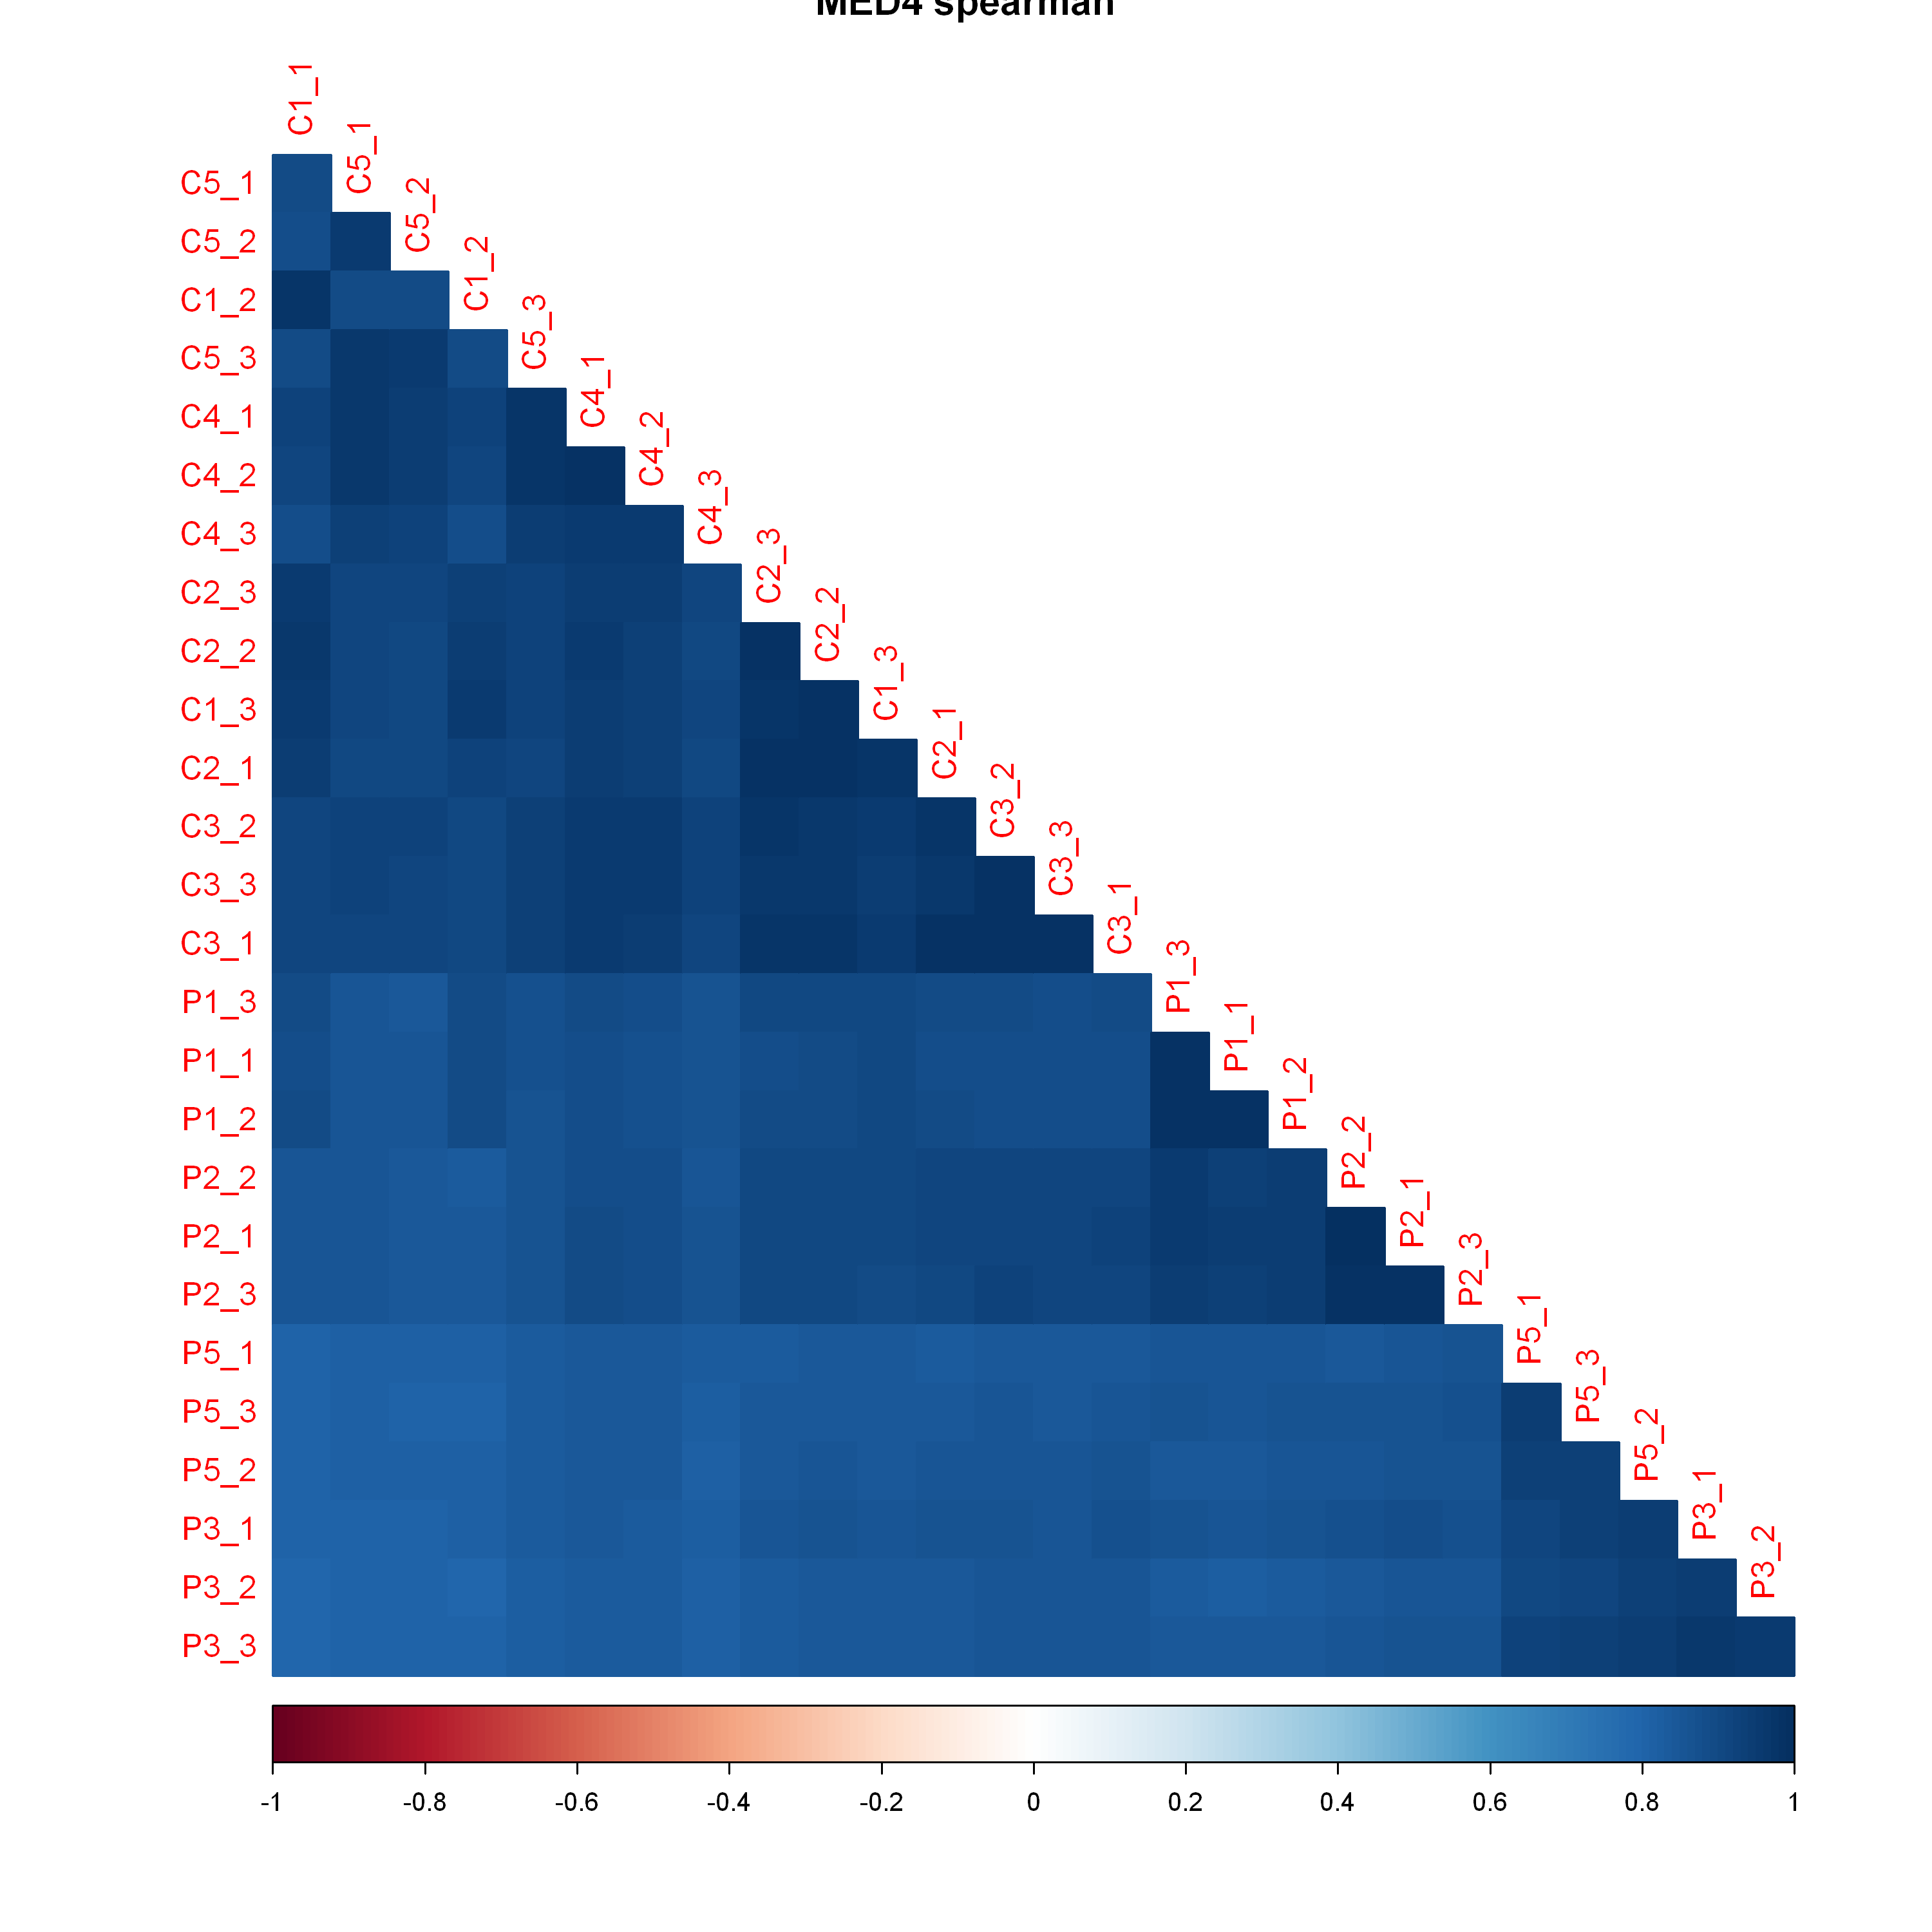

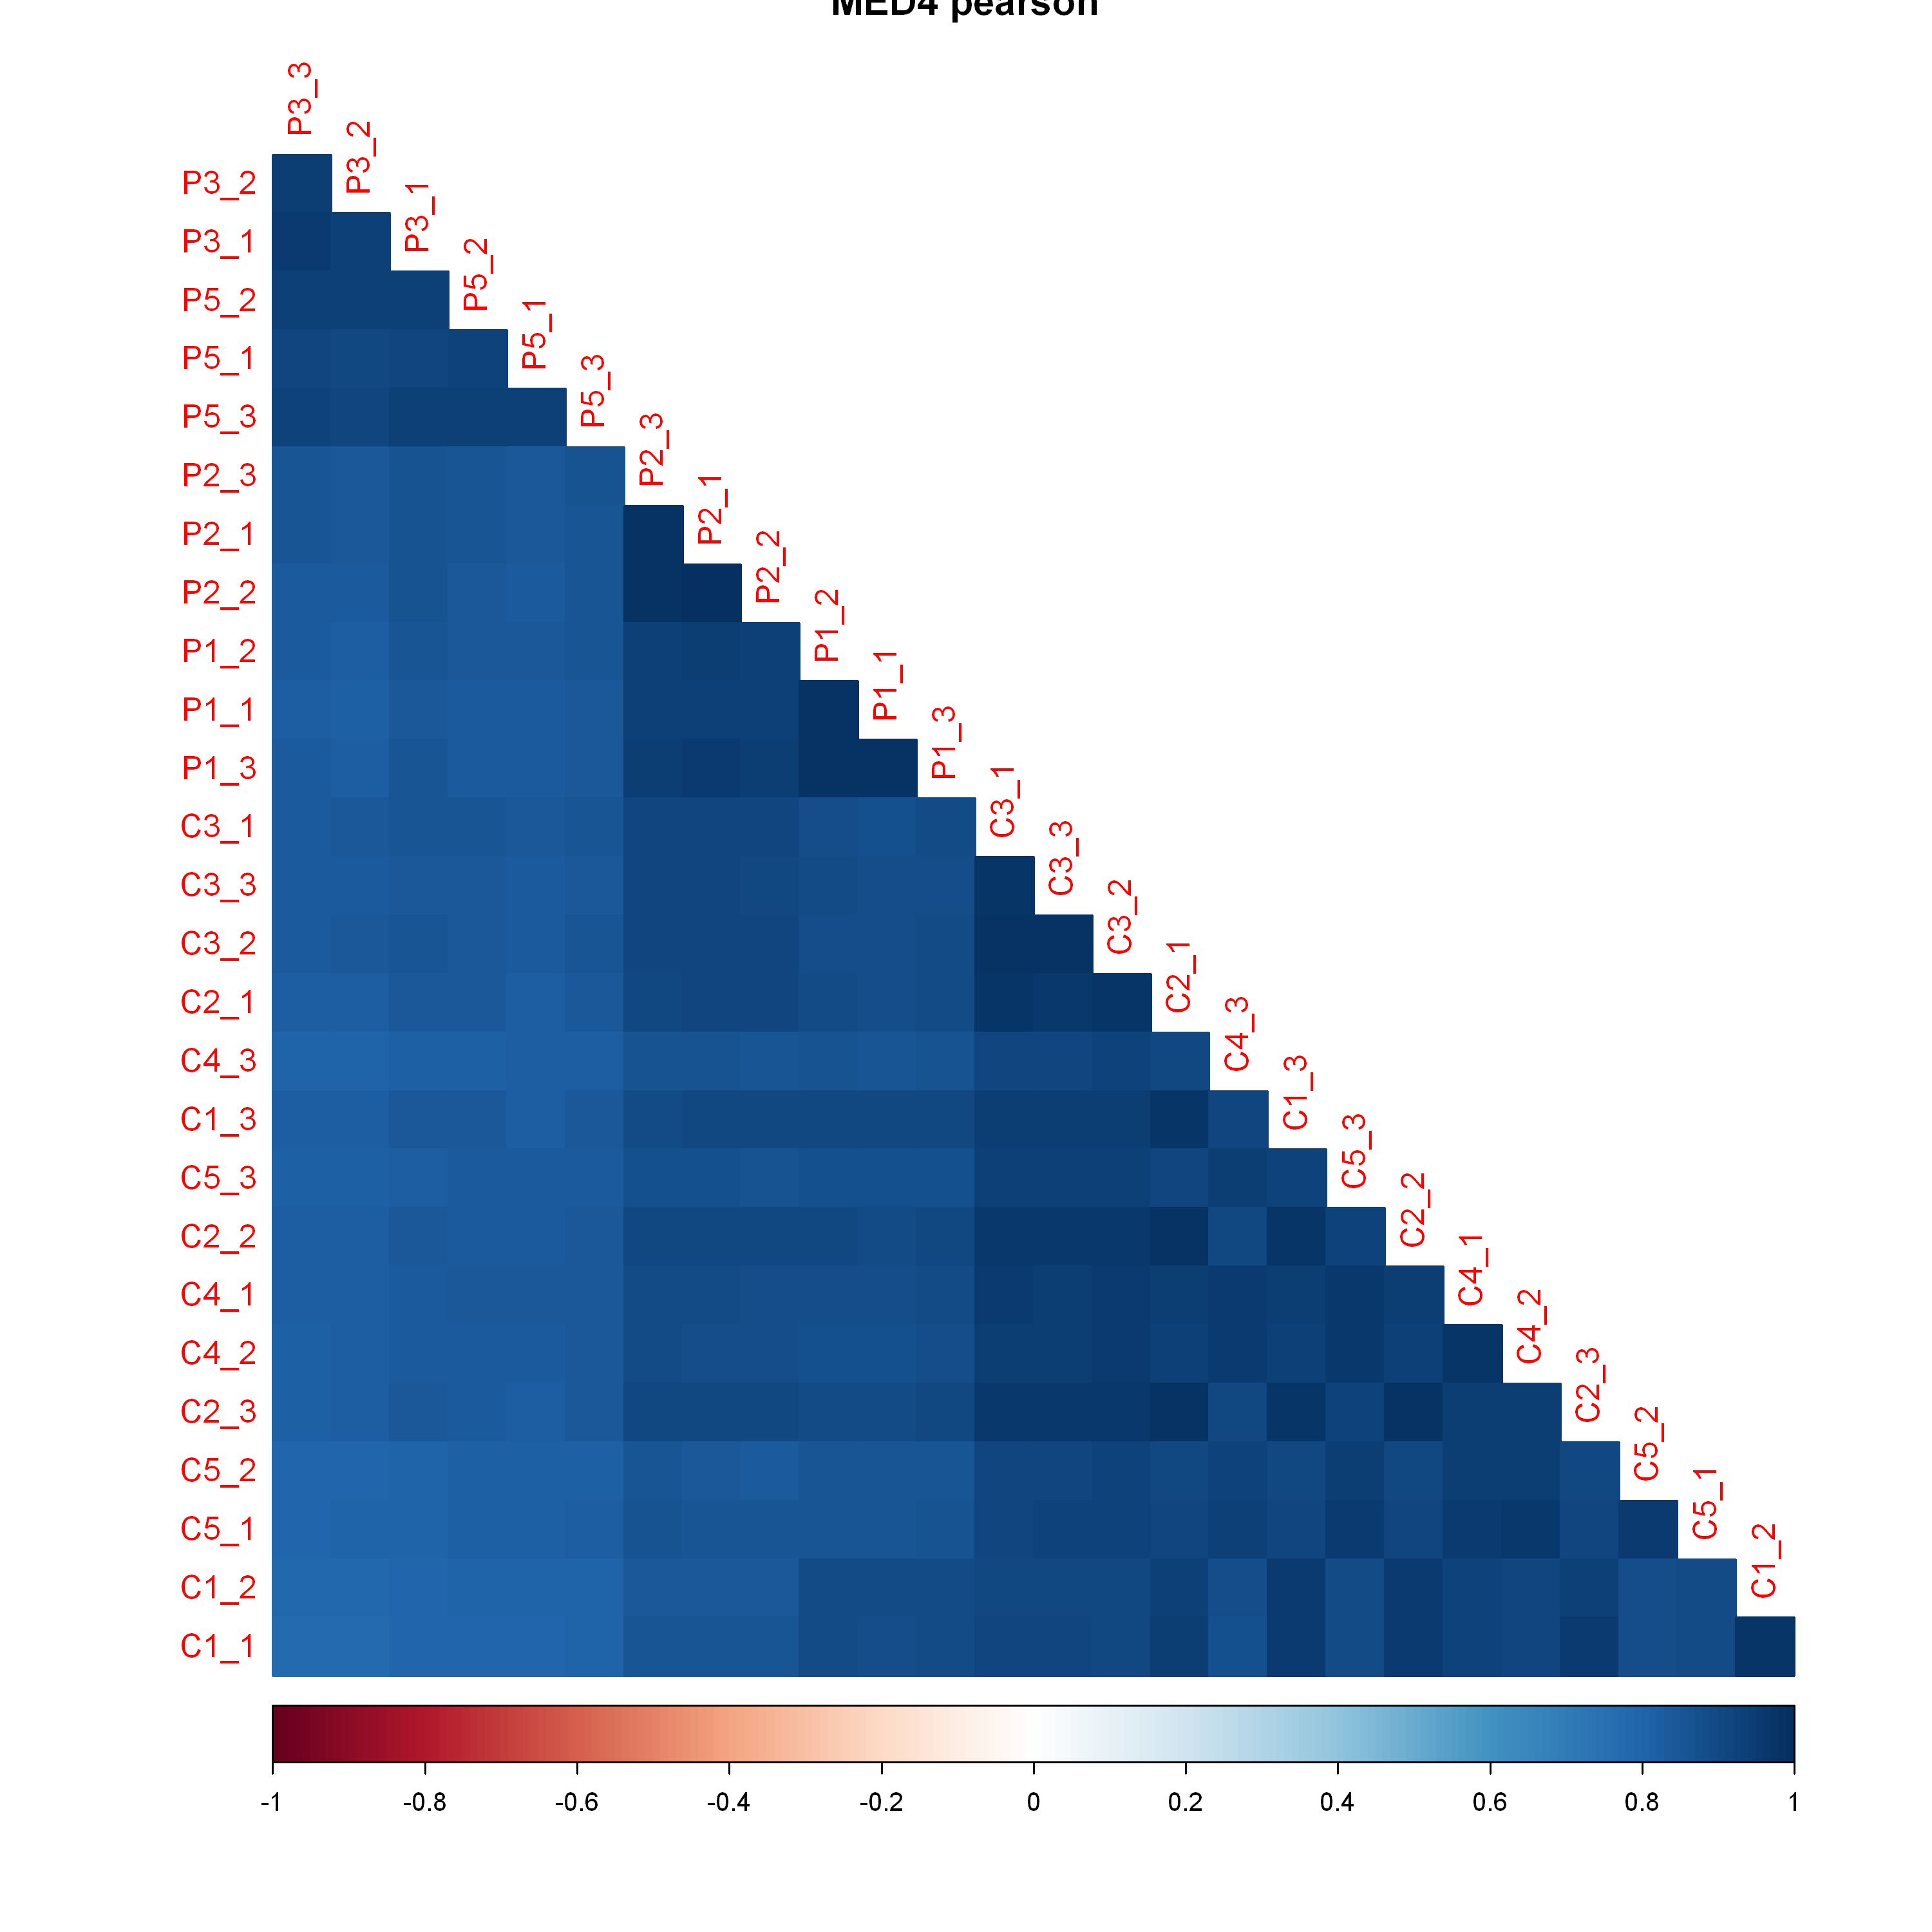

In [28]:
corrplot(spearman_cor, method="color", #tl.cex = .35, 
         order = 'AOE', diag = FALSE, type = 'lower', title='MED4 spearman')
corrplot(pearson_cor, method="color", #tl.cex = .35, 
         order = 'AOE', diag = FALSE, type = 'lower',title='MED4 pearson')


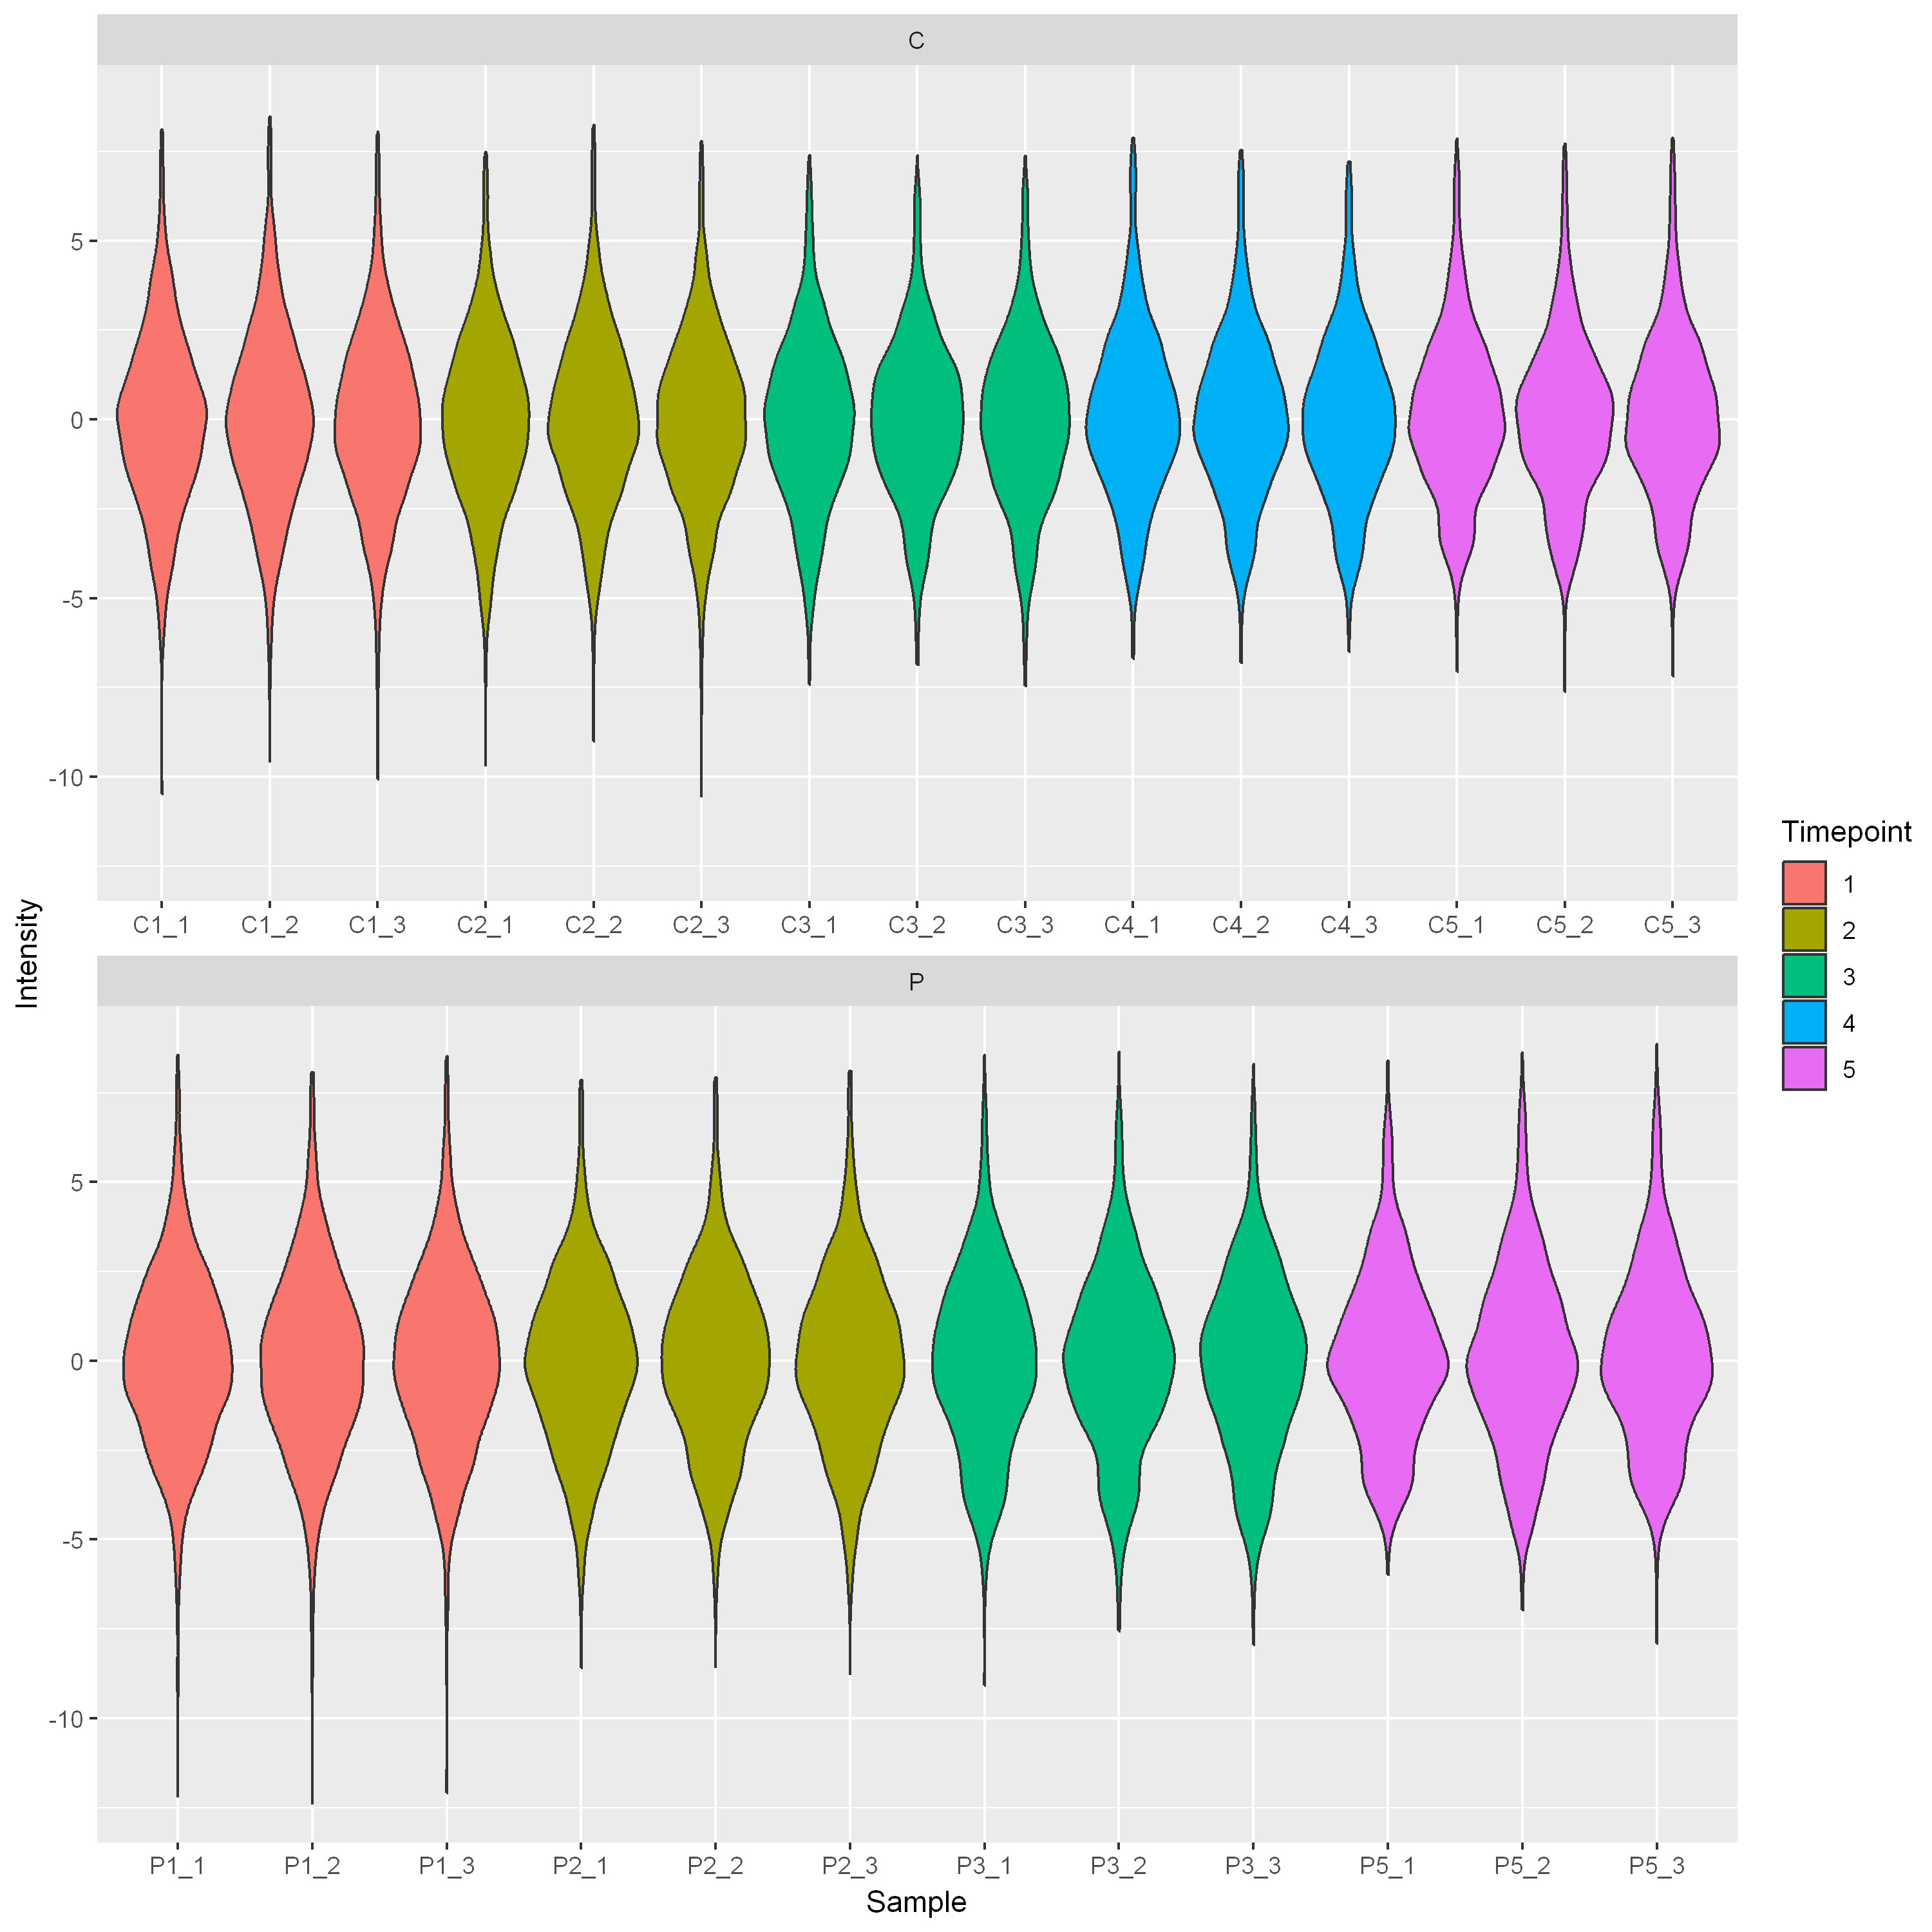

In [35]:
mdf %>%
ggplot(aes(x=Sample, y=Intensity, fill=Timepoint)) +
   geom_violin() +
facet_wrap(~Group, scales = "free_x", ncol=1)

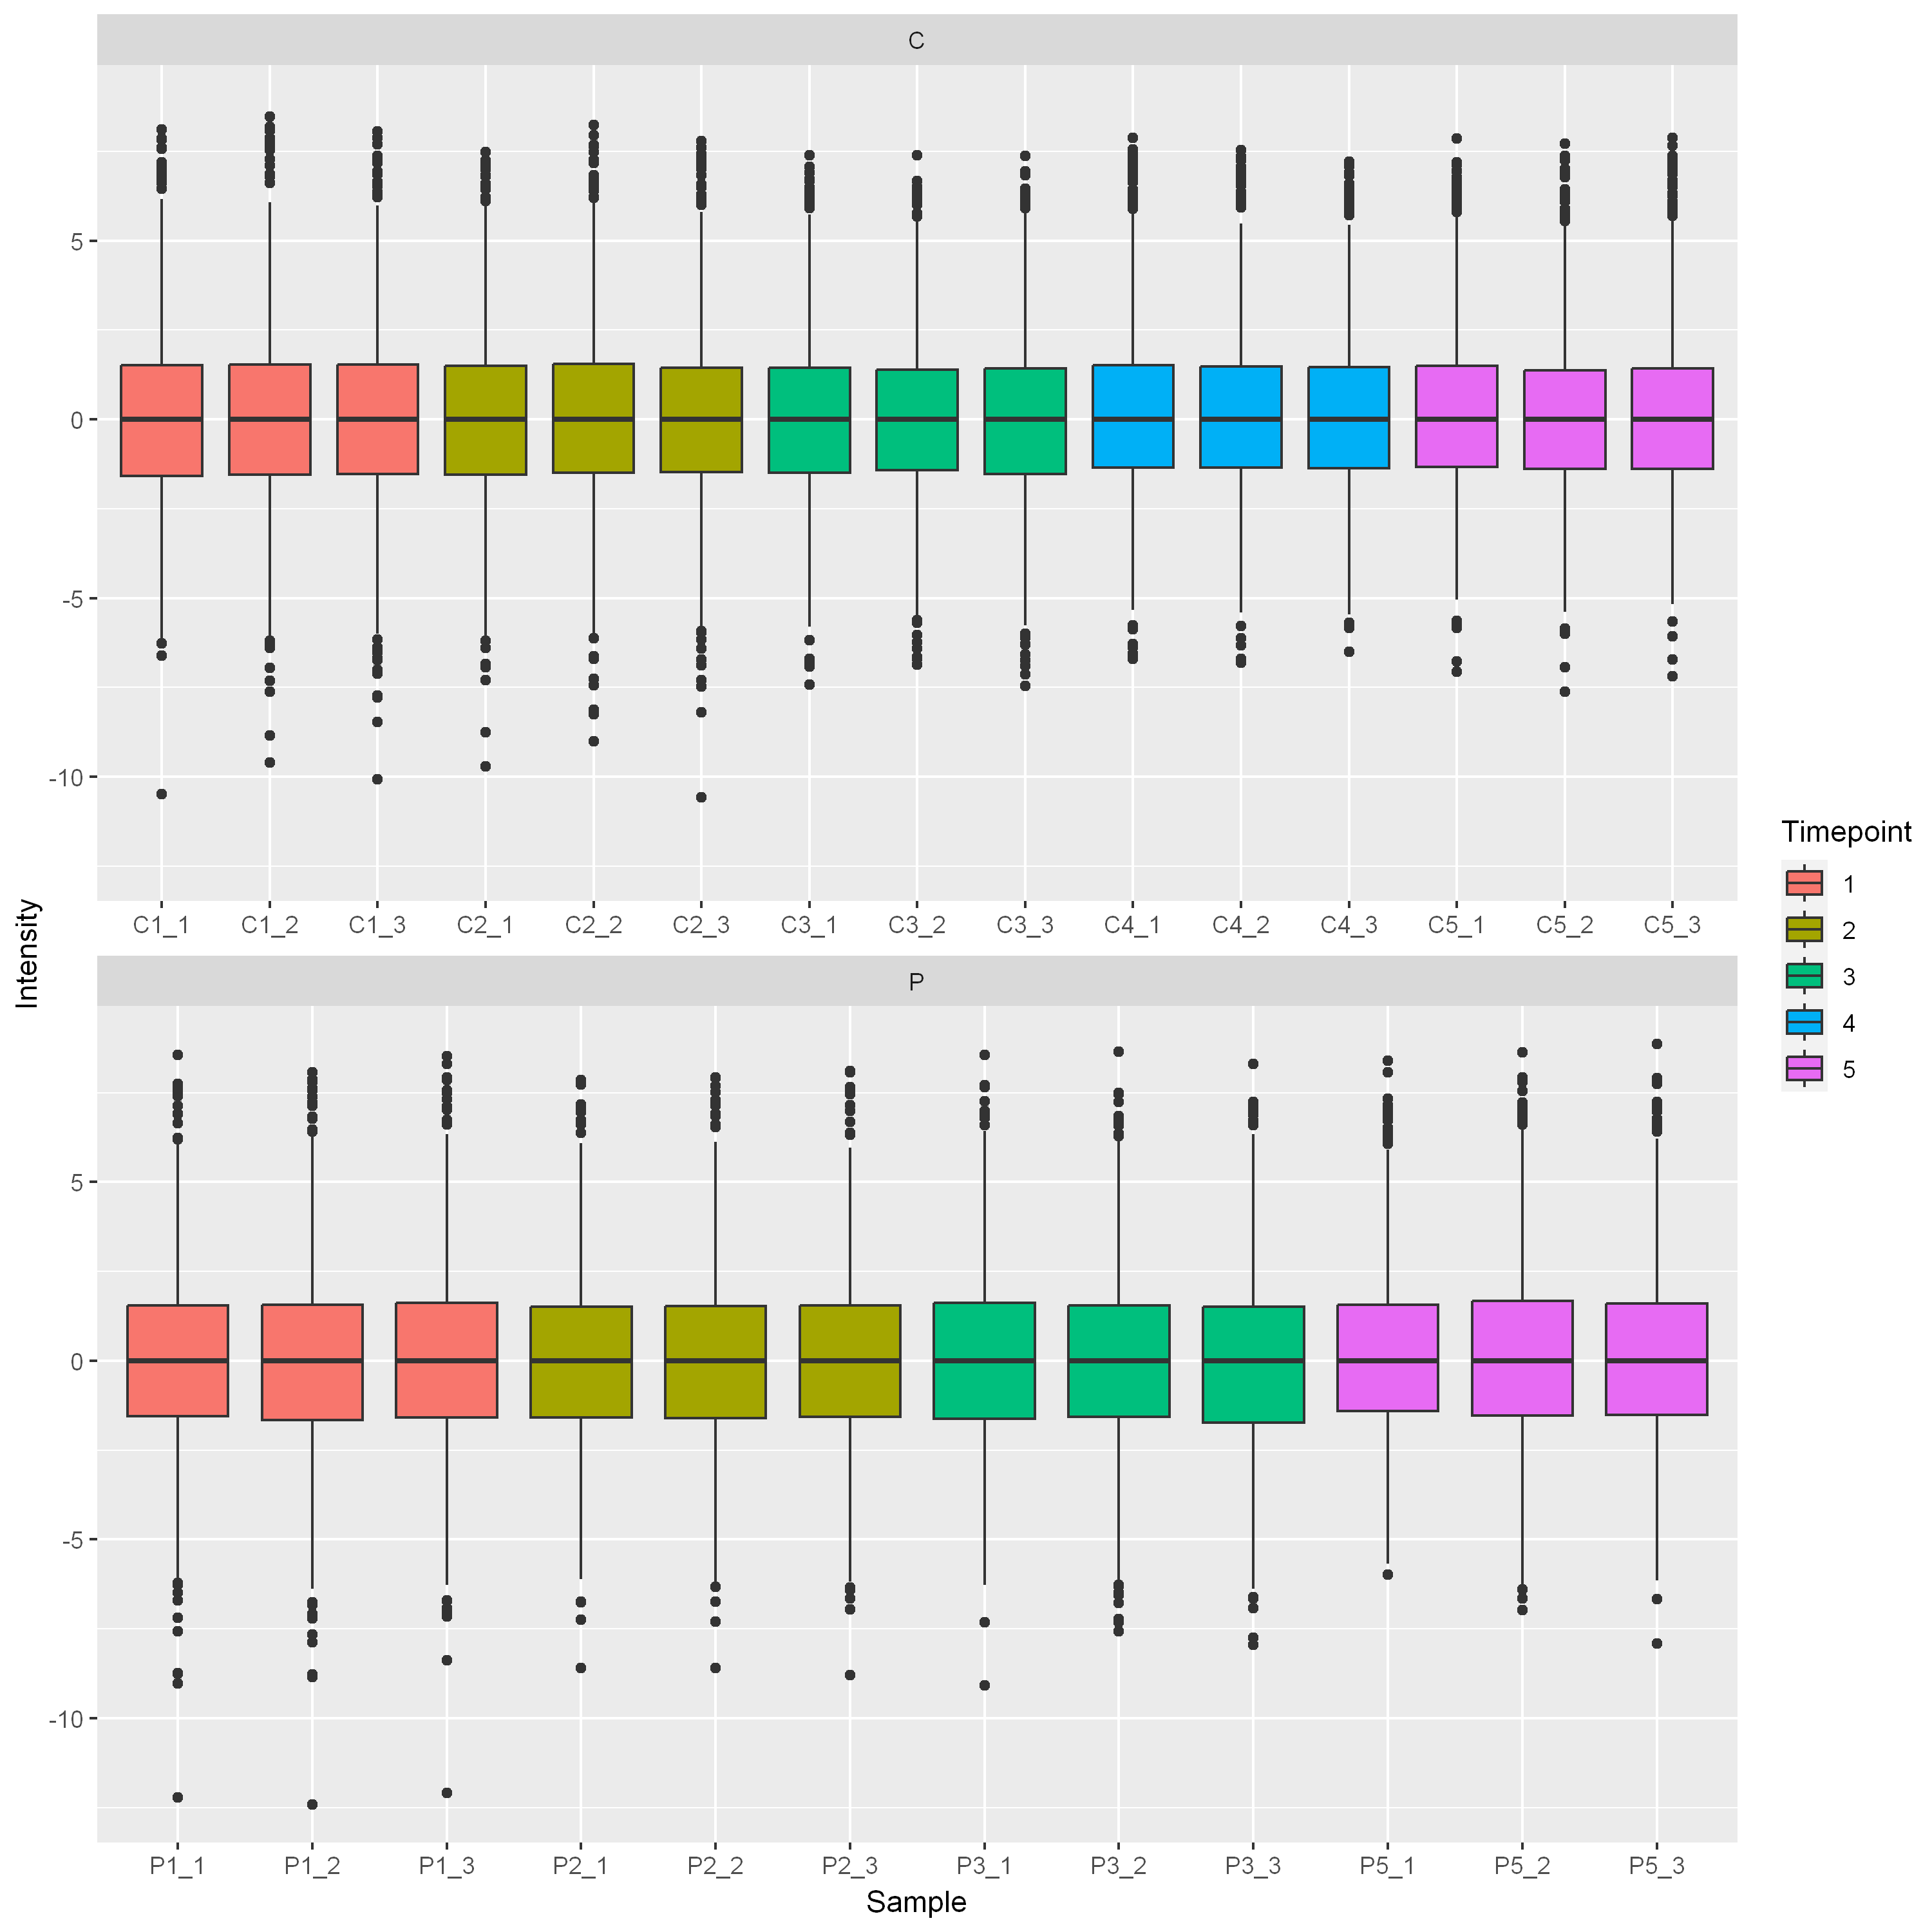

In [36]:
mdf %>%
ggplot(aes(x=Sample, y=Intensity, fill=Timepoint)) +
   geom_boxplot() +
facet_wrap(~Group, scales = "free_x", ncol=1)